# Init

In [21]:

import os
import pickle
import pandas as pd
# from postProcessingFunctions import processOutputs, replaceValueInFile, parallelizeFunction, genExtList
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gumbel_r, gumbel_l
from scipy.stats import genextreme

import re

import numpy as np

from IPython.display import display, Markdown

import moorpy as mp
import copy

from moorpy_functions import genMoorpySys2


In [22]:
resultsFol = r'..\results'
dataFol = r'..\data'

yamlFile = os.path.join(dataFol, "P200_C135_L1430_clump40.yaml")
sumDf_path = os.path.join(resultsFol, r"P200_C135_L1430_clump40_extreme.parquet")

anchorExtEventsDf_path = os.path.join(resultsFol, r"P200_C135_L1430_clump40_extreme_anchorExtremeEvents.parquet")
anchorExtStatsDf_path = os.path.join(resultsFol, r"P200_C135_L1430_clump40_extreme_anchorExtremeStats.parquet")
sumDf = pd.read_parquet(sumDf_path)
anchorExtEventsDf = pd.read_parquet(anchorExtEventsDf_path)
anchorExtStatsDf = pd.read_parquet(anchorExtStatsDf_path)
ext_envCond = pd.read_excel(os.path.join(dataFol, r"extreme_envCond.xlsx"), index_col=0)

# anchorExtEventsDf = anchorExtEventsDf.droplevel(level=1)
anchorExtStatsDf = anchorExtStatsDf.droplevel(level=1)

bodyYaml = os.path.join(dataFol, r"15MW_bdy.yaml")

(<Figure size 600x400 with 1 Axes>, <Axes3D: >)

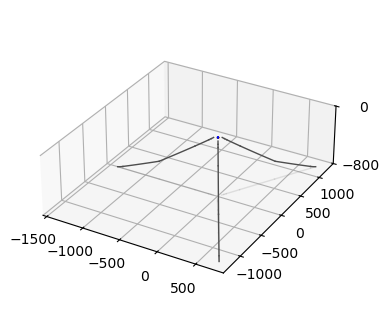

In [23]:

ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.plot()


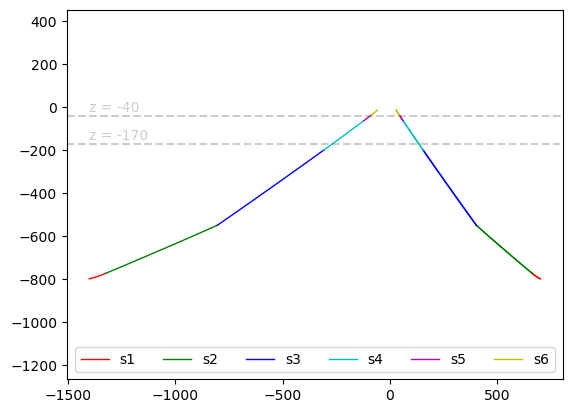

In [24]:

ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
fig, ax = plt.subplots(1, 1,)
ms.plot2d(ax = ax)
lines = ax.get_lines()

colGroups = {'s1' : ([1, 7, 13], 'r'),
             's2' : ([2, 8, 14], 'g'),
             's3' : ([3, 9, 15], 'b'),
             's4' : ([4, 10, 16], 'c'),
             's5' : ([5, 11, 17], 'm'),
             's6' : ([6, 12, 18], 'y')}

legendList = []
for id in colGroups:
    for ind, i in enumerate(colGroups[id][0]):
        lines[i-1].set_color(colGroups[id][1])
        if ind == 0:
            legendList.append(lines[i-1])
        
        

# ax.set_ylim(-900,)
ax.axhline(-170, color = 'k', linestyle = '--', alpha = 0.2)
ax.text(-1400, -170+20, 'z = -170', color = 'k', alpha = 0.2)

ax.axhline(-40, color = 'k', linestyle = '--', alpha = 0.2)
ax.text(-1400, -40+20, 'z = -40', color = 'k', alpha = 0.2)

#put legend outside the plot in
ax.legend(legendList, colGroups.keys(), loc = 'lower center', bbox_to_anchor=(0.5, 0), ncol = 6)


In [25]:
def extractInfoFromIndex(index):

    #Extract information about the run from the index
    match = re.match(r"Run_P(\d+)_C(\d+)_.*_([a-z,A-Z,\d,.,_]+)_(\d+)_S(\d+).*.outb", index)

    if match:
        return match.groups()
    else:
        raise ValueError(f"Index {index} does not match the pattern")




def checkDataFrame(df):
    if df.isna().any().any():
        raise ValueError("DataFrame contains NA values")
    

def displayDf(df, nCols = 5):

    for i in range(0, len(df.columns), nCols):
        display(Markdown(df.iloc[:, i:i+nCols].to_markdown()))



def checkTensionExtremes(sumDf, valHeader, valType='max', head=None):
    """
    Function which determines the critical tension to be considered 
    """
    
    # Select the max values from the DataFrame based on valType and valHeader
    df = sumDf.xs(valType, axis=1, level=1).loc[:, valHeader].copy()
     
    # Find the column with the max or min tension value for each row based on valType
    if valType == 'max':
        df['maxTenCol'] = df.idxmax(axis=1)
        df['maxTen'] = df.iloc[:,:-1].max(axis=1) # Exclude the last column which contains the name of the column with the max value
    elif valType == 'min':
        df['minTenCol'] = df.idxmin(axis=1)
        df['minTen'] = df.iloc[:,:-1].min(axis=1)
    else:
        raise ValueError("valType must be either 'max' or 'min'")
    
    # Add additional columns from the original DataFrame
    df['cond_head'] = sumDf['cond_head']
    df['seed'] = sumDf['seed']
    df['heading'] = sumDf['heading']
    df['polyDia'] = sumDf['polyDia']
    

    # Filter by the specified heading
    if head is not None:
        df = df[df['heading'] == head]

    if valType == 'max':
        val = df['maxTen'].max()
        loc = df['maxTen'].idxmax()
    elif valType == 'min':
        val = df['minTen'].min()
        loc = df['minTen'].idxmin()

    # Print unique maximum tension columns
    print(f'{valType} tensions occurring in {df[f"{valType}TenCol"].unique()} and val is {val} @ {loc}')
    
    return df



# ---------- Some Moorpy functions ----------

# def printMsStats(mpySys, topChainLineIndex, topChainLineIndex, waterDepth):

#     print('Body location')
#     print(f'{mpySys.bodyList[0].r6}')

#     topTenList = []

    
        
#         for ind, (lineId, pointId) in enumerate(zip(topChainLineIndex, bottomChainTopPointIndex)):

#             print(f'Line {ind + 1}')
#             if moorpyVersion == '1.1.0' :
#                 print(f'Top tension : {mpySys.lineList[lineId-1].getTension(s = 1)/1000:.2f} kN') #tension at the top of the chain - end B
#                 print(f'Anchor tension : {mpySys.lineList[lineId-1].getTension(s = 0)/1000:.2f} kN') #tension at the anchor - end A
#             else:
#                 print(f'Top tension : {mpySys.lineList[lineId-1].getLineTens()[-1]/1000:.2f} kN')
#                 print(f'Anchor tension : {mpySys.lineList[lineId-1].getLineTens()[0]/1000:.2f} kN')
#             print(f'z locaton of transition top of btm chain : {mpySys.pointList[pointId].r[2] + waterDepth:.2f} m')
#             topTenList.append(mpySys.lineList[lineId-1].getTension(s = 1))

#     else :

#         print('Body location')
#         print(f'{mpySys.bodyList[0].r6}')

#         print('Line 1')
#         print(f'Top tension : {mpySys.lineList[2].getLineTens()[-1]/1000:.2f} kN') #tension at the top of the chain - end B
#         print(f'Anchor tension : {mpySys.lineList[0].getLineTens()[0]/1000:.2f} kN') #tension at the anchor - end A
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[1].r[2] + 800:.2f} m')

#         print('Line 2')
#         print(f'Top tension : {mpySys.lineList[5].getLineTens()[-1]/1000:.2f} kN') 
#         print(f'Anchor tension : {mpySys.lineList[3].getLineTens()[0]/1000:.2f} kN')
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[5].r[2] + 800:.2f} m')

#         print('Line 3')
#         print(f'Top tension : {mpySys.lineList[8].getLineTens()[-1]/1000:.2f} kN') 
#         print(f'Anchor tension : {mpySys.lineList[6].getLineTens()[0]/1000:.2f} kN') 
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[9].r[2] + 800:.2f} m')
#         preTension = np.mean([mpySys.lineList[2].getLineTens()[-1], mpySys.lineList[5].getLineTens()[-1], mpySys.lineList[8].getLineTens()[-1]])
    
#     preTension = np.mean(topTenList)
#     print(f'Average top tension : {preTension/1000:.2f} kN')

#     return preTension



def getLineTensions(mpySys, lineIndexList, end = 'fA'):

    '''
    lineIndexList : list of line indices - the index as seen in the moorDyn file. The index starts at 1
    s = 0 for end A and s = -1 for end B
    '''

    tensionList = []
    for ind, lineId in enumerate(lineIndexList):


        ten = np.linalg.norm(getattr(mpySys.lineList[lineId-1], end))
        
        
        # ten = mpySys.lineList[lineId-1].getTension(s = s)
     
        # else :
        #     ten = mpySys.lineList[lineId-1].getLineTens()

        #     if s== 0 :
        #         ten = ten[0]
        #     elif s == 1 :
        #         ten = ten[-1]
        #     else :
        #         raise ValueError('s must be 0 or 1 for moorpy version < 1.1.0')

        # ten = mpySys.lineList[lineId-1].getTension(s = s)
        print(f'Line {ind + 1} : {ten/1000:.2f} kN')
        tensionList.append(ten)

    return tensionList



In [62]:
#extract information form the index columns
for df in [sumDf, anchorExtStatsDf, anchorExtEventsDf]:

    if len(df.index[0]) != 1:
        index = df.index.get_level_values(0)
    else :
        index = df.index 
    df[['polyDia', 'chainDia', 'cond', 'heading', 'seed']] = index.map(extractInfoFromIndex).to_list()

    #additional modifications
    df['polyDia']        = df['polyDia'].astype(float)/1000 #convert to meters
    df['chainDia']       = df['chainDia'].astype(float)/1000 #convert to meters
    df['seed']           = df['seed'].str.replace(r'(\d+)', lambda x: x.group(0).zfill(2), regex=True) #change S1 to S01
    df['cond_head']      = df['cond'] + '_' + df['heading']
    df['heading']        = df['heading'].astype(float)

    #check for NA values
    checkDataFrame(df)

# Wave elevation

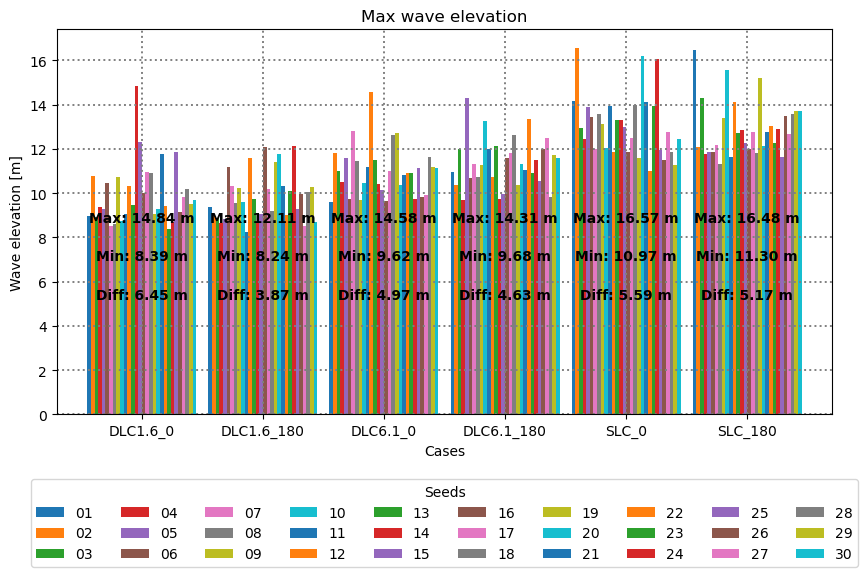

Max wave elevation [m]


| cond_head   |       01 |       02 |       03 |       04 |       05 |       06 |
|:------------|---------:|---------:|---------:|---------:|---------:|---------:|
| DLC1.6_0    |  8.97591 | 10.7908  |  8.93328 |  9.38128 |  9.29067 | 10.4604  |
| DLC1.6_180  |  9.35669 |  8.97846 |  8.88564 |  8.63824 |  8.84338 | 11.1914  |
| DLC6.1_0    |  9.61543 | 11.8198  | 11.0076  | 10.5078  | 11.5928  |  9.73572 |
| DLC6.1_180  | 10.9515  | 10.3458  | 11.9833  |  9.68253 | 14.314   | 10.6628  |
| SLC_0       | 14.1613  | 16.5673  | 12.938   | 12.4589  | 13.9023  | 13.4163  |
| SLC_180     | 16.475   | 12.0892  | 14.3129  | 11.7664  | 11.8552  | 11.8591  |

| cond_head   |       07 |       08 |       09 |       10 |       11 |      12 |
|:------------|---------:|---------:|---------:|---------:|---------:|--------:|
| DLC1.6_0    |  8.50793 |  8.58263 | 10.7049  |  8.74225 |  9.06814 | 10.3393 |
| DLC1.6_180  | 10.3111  |  9.54154 | 10.2277  |  9.58139 |  8.23695 | 11.5724 |
| DLC6.1_0    | 12.8244  | 11.4254  |  9.70415 | 10.4442  | 11.1738  | 14.582  |
| DLC6.1_180  | 11.322   | 10.7311  | 11.2817  | 13.234   | 11.9798  | 10.7177 |
| SLC_0       | 12.0064  | 13.5735  | 13.1263  | 12.0539  | 13.9387  | 11.8635 |
| SLC_180     | 12.1665  | 11.3033  | 13.4054  | 15.5529  | 11.6094  | 14.0957 |

| cond_head   |       13 |       14 |       15 |       16 |      17 |       18 |
|:------------|---------:|---------:|---------:|---------:|--------:|---------:|
| DLC1.6_0    |  9.47437 | 14.8369  | 12.2921  |  9.99726 | 10.9711 | 10.8983  |
| DLC1.6_180  |  9.73468 |  8.69106 |  9.06028 | 12.0779  | 10.163  |  9.20902 |
| DLC6.1_0    | 11.4759  | 10.4286  | 10.1538  |  9.63678 | 10.9785 | 12.6328  |
| DLC6.1_180  | 12.1466  |  9.71005 |  9.94544 | 11.589   | 11.79   | 12.5999  |
| SLC_0       | 13.3134  | 13.3061  | 12.9979  | 11.8672  | 12.473  | 13.9815  |
| SLC_180     | 12.7017  | 12.8674  | 12.2799  | 11.9973  | 12.7378 | 11.8307  |

| cond_head   |       19 |       20 |      21 |       22 |       23 |       24 |
|:------------|---------:|---------:|--------:|---------:|---------:|---------:|
| DLC1.6_0    |  9.03576 |  9.29403 | 11.7796 |  9.41407 |  8.39125 |  8.69186 |
| DLC1.6_180  | 11.3886  | 11.7829  | 10.303  |  9.01233 | 10.0735  | 12.1078  |
| DLC6.1_0    | 12.6916  | 10.376   | 10.8104 | 10.8865  | 10.8858  |  9.74377 |
| DLC6.1_180  | 10.3856  | 11.3135  | 11.0407 | 13.3552  | 10.9227  | 11.5044  |
| SLC_0       | 11.5754  | 16.1696  | 14.1345 | 10.9735  | 13.9154  | 16.0626  |
| SLC_180     | 15.2162  | 12.1377  | 12.7765 | 13.0417  | 12.2385  | 12.8821  |

| cond_head   |       25 |       26 |       27 |       28 |       29 |       30 |
|:------------|---------:|---------:|---------:|---------:|---------:|---------:|
| DLC1.6_0    | 11.8343  |  9.15325 |  9.82031 | 10.1964  |  9.52063 |  9.67216 |
| DLC1.6_180  |  9.27225 |  9.96715 |  8.53076 | 10.0509  | 10.2637  |  8.67699 |
| DLC6.1_0    | 11.1365  |  9.81686 |  9.92564 | 11.6121  | 11.185   | 11.1385  |
| DLC6.1_180  | 10.5561  | 11.9984  | 12.4843  |  9.81218 | 11.6983  | 11.5713  |
| SLC_0       | 11.9245  | 11.5086  | 12.7563  | 11.8726  | 11.2824  | 12.4577  |
| SLC_180     | 11.6082  | 13.4792  | 12.6665  | 13.5876  | 13.6856  | 13.7269  |

| cond_head   |      min |     max |
|:------------|---------:|--------:|
| DLC1.6_0    |  8.39125 | 14.8369 |
| DLC1.6_180  |  8.23695 | 12.1078 |
| DLC6.1_0    |  9.61543 | 14.582  |
| DLC6.1_180  |  9.68253 | 14.314  |
| SLC_0       | 10.9735  | 16.5673 |
| SLC_180     | 11.3033  | 16.475  |

In [64]:
valHeader = ['Wave1Elev']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']


pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='Wave1Elev')


# pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
# pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
# pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Cases')
plt.ylabel('Wave elevation [m]')
plt.xticks(rotation=0)
plt.title('Max wave elevation')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Max wave elevation [m]')
displayDf(pivot_df, nCols = 6)

# Caculate pretensions

## Installed

None
Top tensions are[2032.7194906451925, 2029.1959518323126, 2032.719490649366] kN
Average top tension is 2031.544977708957 kN
Body postion is [ 4.21718157e-01 -3.77588067e-12 -8.85077248e-01 -1.36315569e-15
 -2.47842153e-02  3.70516017e-14]


(<Figure size 600x400 with 1 Axes>, <Axes: >)

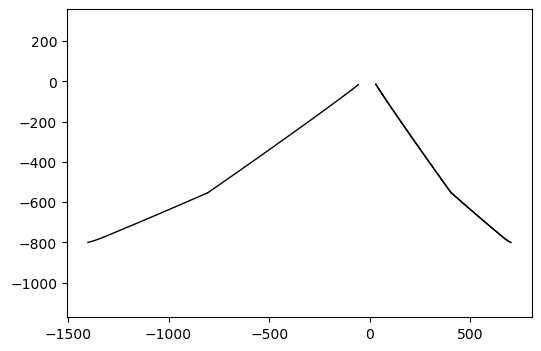

In [29]:
ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.bodyList[0].type = 0

conv = ms.solveEquilibrium3(tol=0.0001)
print(conv)

#Top tensions
topTen = [np.linalg.norm(ms.lineList[5].fB)/1000, np.linalg.norm(ms.lineList[11].fB)/1000, np.linalg.norm(ms.lineList[17].fB)/1000]

print(f'Top tensions are{topTen} kN')

print(f'Average top tension is {np.mean(topTen)} kN', )

print(f'Body postion is {ms.bodyList[0].r6}', )

ms.plot2d(color = 'k')

## Installation

Top tensions are[1050.1620189803143, 1048.172075738446, 1050.1620189798143] kN
Average top tension is 1049.4987045661917 kN
Body postion is [ 4.80368586e-01  5.15659853e-12 -4.67188635e-01  7.53423539e-16
 -2.57079181e-02  3.20874688e-17]


(<Figure size 600x400 with 1 Axes>, <Axes: >)

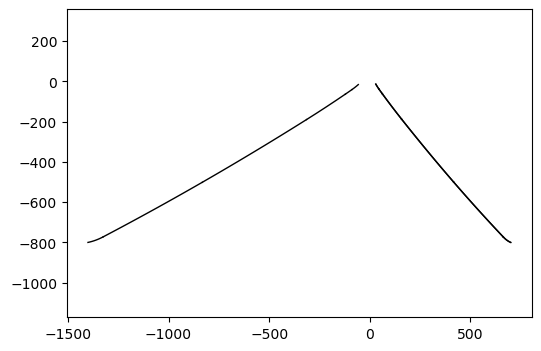

In [30]:


ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.bodyList[0].type = 0

for id in [3, 10, 17]: #set clump weights to zero
    ms.pointList[id-1].m = 0

conv = ms.solveEquilibrium3(tol=0.0001)

#Top tensions
topTen = [np.linalg.norm(ms.lineList[5].fB)/1000, np.linalg.norm(ms.lineList[11].fB)/1000, np.linalg.norm(ms.lineList[17].fB)/1000]

print(f'Top tensions are{topTen} kN')

print(f'Average top tension is {np.mean(topTen)} kN', )
print(f'Body postion is {ms.bodyList[0].r6}', )

ms.plot2d(color = 'k')

# Line properties

In [31]:
if sumDf['polyDia'].nunique() != 1 or sumDf['chainDia'].nunique() != 1:
    raise ValueError('Multiple MBLs for the same diameter')

polyDia = sumDf['polyDia'].unique()[0]
chainDia = sumDf['chainDia'].unique()[0]

linePropsDf = pd.read_csv(os.path.join(dataFol,r'lineProps.csv')) #get the line properties to calcualte the safety factor
polyDat = (linePropsDf['lineType'] == 'polyester') & (linePropsDf['dt_mg'] == 0.05) & (linePropsDf['dt_corr'] == 0) & (linePropsDf['nomDia'] == polyDia)
botChainDat = (linePropsDf['lineType'] == 'sl_chain') & (linePropsDf['dt_mg'] == 0.05) & (linePropsDf['dt_corr'] == 0.01) & (linePropsDf['nomDia'] == chainDia)
topChainDat = (linePropsDf['lineType'] == 'sl_chain') & (linePropsDf['dt_mg'] == 0.1) & (linePropsDf['dt_corr'] == 0.01) & (linePropsDf['nomDia'] == chainDia)

lineDf = linePropsDf.loc[polyDat | botChainDat | topChainDat, :]


polyMbl = lineDf.loc[polyDat, 'mbl'].values[0]

displayDf(lineDf, 5)




|    | lineType   |   nomDia |   dt_mg |   dt_corr |   massDensity |
|---:|:-----------|---------:|--------:|----------:|--------------:|
| 29 | polyester  |    0.2   |    0.05 |      0    |       79.1926 |
| 81 | sl_chain   |    0.135 |    0.05 |      0.01 |      441.508  |
| 84 | sl_chain   |    0.135 |    0.1  |      0.01 |      560.143  |

|    |   subWeight |   volEqDia |         mbl | EA                                    |   transDrag_eqDia |
|---:|------------:|-----------:|------------:|:--------------------------------------|------------------:|
| 29 |     184.861 |   0.273796 | 1.232e+07   | [172480000.00000003, (11.615, 0.396)] |           1.75313 |
| 81 |    3280.46  |   0.364759 | 1.42868e+07 | 1559963307.2625003                    |           1.54623 |
| 84 |    3543.96  |   0.49704  | 1.42868e+07 | 1559963307.2625003                    |           1.61758 |

|    |   longDrag_eqDia |   transAddedMass_eqDia |   longAddedMass_eqDia |
|---:|-----------------:|-----------------------:|----------------------:|
| 29 |         0        |                1.32063 |              0.180086 |
| 81 |         0.740901 |                1.34484 |              0.672418 |
| 84 |         0.775088 |                1.47181 |              0.735905 |

# Assumptions


- Line slackness check
  - SLC condition is considered for strength check of lines. Line slackness check fails for SLC condition -> pretension will have to be very high and higher line diameter will be required if this has to be satisfied.
- Only aligned WWC (wind wave current) has been considered - both along the line (0 deg. heading) and between the line (180 deg) condition is considered.
- Current modelling
  - Current loading on the platform accounted by applying a constant force calculated based on the surface current velocity and quadratic drag coefficient of the platform
  - Current loading on the mooring line is considered by considering a linear profile of the current velocity along the water depth 
- Wave loads acting on the mooring line is not considered.


# Mean line tension at fairlead

* Environment : WWC aligned, 0 deg heading
* Line considered : Line 2

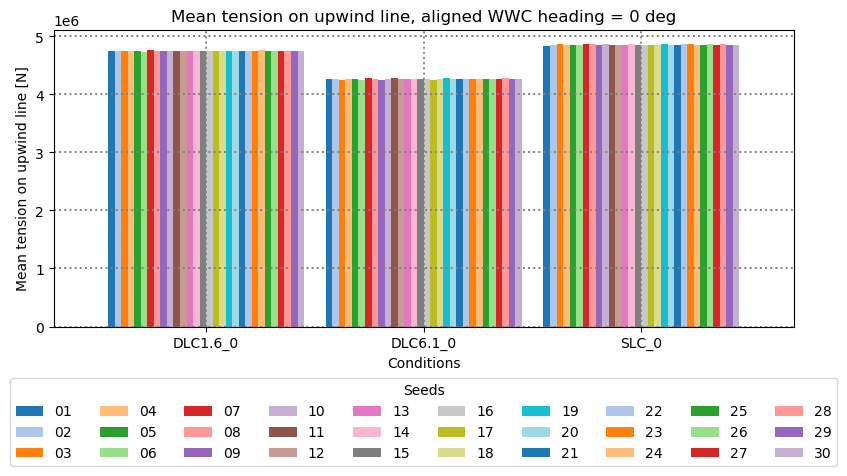

Mean tensions [N] on upwind line, aligned WWC heading = 0 deg


| cond_head   |          01 |          02 |          03 |          04 |          05 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.74796e+06 | 4.74164e+06 | 4.74972e+06 | 4.75085e+06 | 4.74882e+06 |
| DLC6.1_0    | 4.26365e+06 | 4.26544e+06 | 4.25097e+06 | 4.25677e+06 | 4.26898e+06 |
| SLC_0       | 4.83767e+06 | 4.85078e+06 | 4.85915e+06 | 4.85178e+06 | 4.85718e+06 |

| cond_head   |          06 |          07 |          08 |          09 |          10 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.73471e+06 | 4.7552e+06  | 4.74792e+06 | 4.74447e+06 | 4.74396e+06 |
| DLC6.1_0    | 4.25299e+06 | 4.28194e+06 | 4.25767e+06 | 4.25194e+06 | 4.26442e+06 |
| SLC_0       | 4.84427e+06 | 4.86575e+06 | 4.8604e+06  | 4.85526e+06 | 4.87172e+06 |

| cond_head   |          11 |          12 |          13 |          14 |          15 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.74573e+06 | 4.74644e+06 | 4.74438e+06 | 4.74022e+06 | 4.74231e+06 |
| DLC6.1_0    | 4.27519e+06 | 4.26361e+06 | 4.26847e+06 | 4.25677e+06 | 4.26938e+06 |
| SLC_0       | 4.84882e+06 | 4.8414e+06  | 4.85145e+06 | 4.85776e+06 | 4.85725e+06 |

| cond_head   |          16 |          17 |          18 |          19 |          20 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.73909e+06 | 4.74504e+06 | 4.75299e+06 | 4.74656e+06 | 4.74551e+06 |
| DLC6.1_0    | 4.25983e+06 | 4.25391e+06 | 4.26829e+06 | 4.27676e+06 | 4.27142e+06 |
| SLC_0       | 4.85274e+06 | 4.8424e+06  | 4.857e+06   | 4.86298e+06 | 4.85052e+06 |

| cond_head   |          21 |          22 |          23 |          24 |          25 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.74682e+06 | 4.75044e+06 | 4.74203e+06 | 4.76006e+06 | 4.74904e+06 |
| DLC6.1_0    | 4.26384e+06 | 4.26394e+06 | 4.25997e+06 | 4.26555e+06 | 4.27183e+06 |
| SLC_0       | 4.85663e+06 | 4.8592e+06  | 4.86028e+06 | 4.85068e+06 | 4.85322e+06 |

| cond_head   |          26 |          27 |          28 |          29 |          30 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.75205e+06 | 4.73921e+06 | 4.74547e+06 | 4.74192e+06 | 4.7419e+06  |
| DLC6.1_0    | 4.26013e+06 | 4.26671e+06 | 4.27479e+06 | 4.27162e+06 | 4.26917e+06 |
| SLC_0       | 4.86512e+06 | 4.85637e+06 | 4.86164e+06 | 4.84846e+06 | 4.85614e+06 |

MeanTension/MBL % = 37.52


In [32]:
valHeader = ['FAIRTEN12']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']

head = 0  #heading to be analyzed
maxPd = maxPd[maxPd['heading'] == head]


pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df.plot(kind='bar', figsize=(9, 5), width=0.9, color = plt.cm.tab20.colors)

plt.xlabel('Conditions')
# plt.ylabel('FAIRTEN6_max [N]')
plt.ylabel('Mean tension on upwind line [N]')
plt.xticks(rotation=0)
plt.title(f'Mean tension on upwind line, aligned WWC heading = {head} deg')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.tight_layout()
plt.show()

print(f"Mean tensions [N] on upwind line, aligned WWC heading = {head} deg")


displayDf(pivot_df, nCols = 5)

print(f'MeanTension/MBL % = {np.mean(pivot_df.values)/polyMbl * 100:.2f}')


# Comparison of mean of tension from dynamic simulations and value used for stiffness calculation

In [33]:
valHeader = [col[0] for col in sumDf.columns if col[1] == 'mean' and ('FAIR' in col[0] or 'ANCH' in col[0]) and ('HORZ' not in col[0])]

valType   = 'mean'
meanPd    = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy()
nSeg = meanPd.shape[1]//2


moorpyTenPd = pd.read_parquet(os.path.splitext(sumDf_path)[0] + '_meanLineTensions.parquet')
# moorpyTenPd.index = moorpyTenPd.index.str.replace('Run_P200','Run_Moordyn_P200')
moorpyTenPd.index = moorpyTenPd.index + '.outb'

diff = (meanPd  - moorpyTenPd)/moorpyTenPd*100

print(f'Max difference between Moorpy and OpenFAST tensions {diff.abs().max().max():.2f}% at {diff.abs().idxmax().max()}' )



Max difference between Moorpy and OpenFAST tensions 0.58% at Run_P200_C135_L1430_clump40_SLC_180_S16.outb


# Max line tension at fairlead

* Environment : WWC aligned, 0 deg heading
* Line considered : Line 2

## Polyester

In [34]:
valHeader = [f'{ten}{ind}' for ind in range(7,13) for ten in ['ANCHTEN', 'FAIRTEN']]
valType   = 'max'
head = 0
maxPd = checkTensionExtremes(sumDf, valHeader, valType, head)
maxPd


max tensions occurring in ['FAIRTEN12'] and val is 7617716.5 @ Run_P200_C135_L1430_clump40_SLC_0_S11.outb


,ANCHTEN7,FAIRTEN7,ANCHTEN8,FAIRTEN8,ANCHTEN9,FAIRTEN9,ANCHTEN10,FAIRTEN10,ANCHTEN11,FAIRTEN11,ANCHTEN12,FAIRTEN12,maxTenCol,maxTen,cond_head,seed,heading,polyDia
Run_P200_C135_L1430_clump40_DLC1.6_0_S1.outb,5497288.0,5603812.5,5603788.0,5619080.0,5799760.5,5814403.5,5812491.0,5825549.5,5822562.5,5827613.0,5823865.0,5885144.0,FAIRTEN12,5885144.0,DLC1.6_0,01,0.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_0_S10.outb,5529963.5,5636845.5,5636827.0,5652790.0,5836545.0,5853386.0,5852068.5,5868123.0,5866151.5,5872031.5,5869592.5,5935954.5,FAIRTEN12,5935954.5,DLC1.6_0,10,0.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_0_S11.outb,5510627.5,5617022.5,5616995.0,5631940.5,5811055.0,5825209.5,5823226.5,5835906.0,5832890.5,5837876.5,5834106.5,5895121.5,FAIRTEN12,5895121.5,DLC1.6_0,11,0.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_0_S12.outb,5428867.0,5535505.5,5535481.5,5550921.0,5732514.5,5747648.5,5745832.5,5759295.0,5756450.0,5761613.0,5758032.5,5819952.5,FAIRTEN12,5819952.5,DLC1.6_0,12,0.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_0_S13.outb,5455696.0,5562550.5,5562525.0,5577930.0,5759489.5,5774931.5,5773266.5,5787347.5,5784768.5,5790030.5,5786804.5,5849023.5,FAIRTEN12,5849023.5,DLC1.6_0,13,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Run_P200_C135_L1430_clump40_SLC_0_S5.outb,6266527.5,6372573.0,6372543.0,6386822.5,6560869.0,6572526.5,6569983.5,6579843.5,6575985.5,6580309.5,6575461.5,6631172.5,FAIRTEN12,6631172.5,SLC_0,05,0.0,0.2
Run_P200_C135_L1430_clump40_SLC_0_S6.outb,7022684.0,7128947.0,7128919.0,7142998.5,7315205.5,7325915.0,7323083.0,7331886.5,7327576.5,7331697.0,7326283.5,7383077.5,FAIRTEN12,7383077.5,SLC_0,06,0.0,0.2
Run_P200_C135_L1430_clump40_SLC_0_S7.outb,6804478.5,6911344.0,6911327.5,6926884.0,7106553.0,7122081.5,7120543.0,7136291.5,7134004.5,7139945.0,7137050.5,7205134.5,FAIRTEN12,7205134.5,SLC_0,07,0.0,0.2
Run_P200_C135_L1430_clump40_SLC_0_S8.outb,6571733.0,6678183.0,6678158.5,6693211.0,6871034.5,6885479.5,6883636.5,6897402.5,6894632.0,6900041.0,6896566.0,6960763.0,FAIRTEN12,6960763.0,SLC_0,08,0.0,0.2


In [35]:
valHeader = ['FAIRTEN12']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['maxTenCol']  = maxPd.idxmax(axis = 1)
maxPd['maxTenVal']  = maxPd.iloc[:,:-1].max(axis = 1)
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']
maxPd['polyDia']    = sumDf['polyDia']


#only heading = 0 is of interest
head = 0  #heading to be analyzed
maxPd = maxPd[maxPd['heading'] == head]

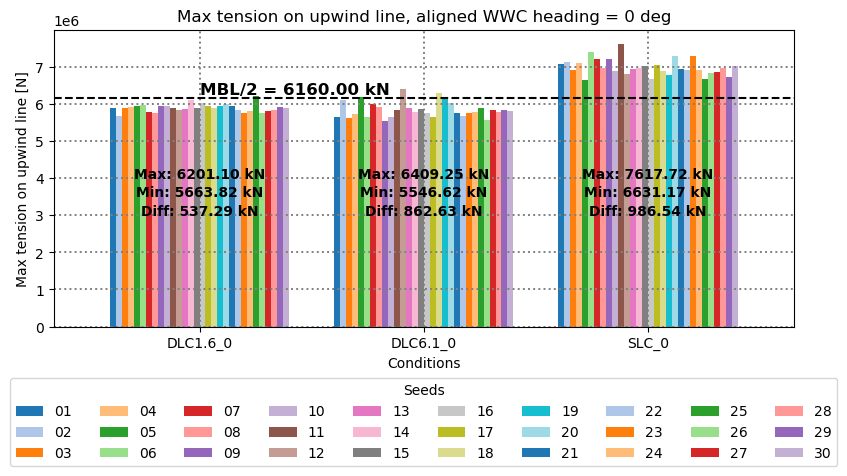

Max tensions [N] on upwind line, aligned WWC heading = 0 deg


| cond_head   |          01 |          02 |          03 |          04 |          05 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.88514e+06 | 5.66382e+06 | 5.87896e+06 | 5.9178e+06  | 5.93275e+06 |
| DLC6.1_0    | 5.63612e+06 | 6.11306e+06 | 5.61593e+06 | 5.72382e+06 | 6.1906e+06  |
| SLC_0       | 7.07163e+06 | 7.1255e+06  | 6.91321e+06 | 7.09045e+06 | 6.63117e+06 |

| cond_head   |          06 |          07 |          08 |          09 |          10 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.95792e+06 | 5.78297e+06 | 5.76039e+06 | 5.93597e+06 | 5.93595e+06 |
| DLC6.1_0    | 5.63718e+06 | 6.00361e+06 | 5.91891e+06 | 5.54662e+06 | 5.65067e+06 |
| SLC_0       | 7.38308e+06 | 7.20513e+06 | 6.96076e+06 | 7.19431e+06 | 6.86993e+06 |

| cond_head   |          11 |          12 |          13 |          14 |          15 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.89512e+06 | 5.81995e+06 | 5.84902e+06 | 6.08969e+06 | 5.89805e+06 |
| DLC6.1_0    | 5.84019e+06 | 6.40925e+06 | 5.87629e+06 | 5.79084e+06 | 5.85563e+06 |
| SLC_0       | 7.61772e+06 | 6.80868e+06 | 6.92299e+06 | 6.95532e+06 | 7.01108e+06 |

| cond_head   |          16 |          17 |          18 |          19 |          20 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 6.03294e+06 | 5.93423e+06 | 5.89105e+06 | 5.93014e+06 | 5.98757e+06 |
| DLC6.1_0    | 5.75531e+06 | 5.63206e+06 | 6.28844e+06 | 6.15846e+06 | 6.01571e+06 |
| SLC_0       | 6.67676e+06 | 7.0366e+06  | 6.89238e+06 | 6.77585e+06 | 7.29227e+06 |

| cond_head   |          21 |          22 |          23 |          24 |          25 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.93087e+06 | 5.83227e+06 | 5.75836e+06 | 5.79783e+06 | 6.2011e+06  |
| DLC6.1_0    | 5.75879e+06 | 5.65716e+06 | 5.7397e+06  | 5.76525e+06 | 5.87533e+06 |
| SLC_0       | 6.93422e+06 | 6.90018e+06 | 7.27676e+06 | 6.90053e+06 | 6.65413e+06 |

| cond_head   |          26 |          27 |          28 |          29 |          30 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.76227e+06 | 5.80329e+06 | 5.83917e+06 | 5.91033e+06 | 5.87828e+06 |
| DLC6.1_0    | 5.56466e+06 | 5.84483e+06 | 5.7682e+06  | 5.83578e+06 | 5.80611e+06 |
| SLC_0       | 6.81518e+06 | 6.84272e+06 | 6.95432e+06 | 6.716e+06   | 7.01342e+06 |

| cond_head   |   gumbel_loc |   gumbel_scale |         max |         min |
|:------------|-------------:|---------------:|------------:|------------:|
| DLC1.6_0    |  5.84022e+06 |          95134 | 6.2011e+06  | 5.66382e+06 |
| DLC6.1_0    |  5.74701e+06 |         158746 | 6.40925e+06 | 5.54662e+06 |
| SLC_0       |  6.87972e+06 |         179581 | 7.61772e+06 | 6.63117e+06 |

In [36]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df.plot(kind='bar', figsize=(9, 5), width=0.8, color = plt.cm.tab20.colors)

plt.ylabel('Max tension on upwind line [N]')
plt.xticks(rotation=0)
plt.title(f'Max tension on upwind line, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.tight_layout()

seedColNames = pivot_df.columns
pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
pivot_df['max'] = pivot_df[seedColNames].max(axis=1) #these two should be after the gumbel fit !!!! -otherwise
pivot_df['min'] = pivot_df[seedColNames].min(axis=1)

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]/1000:.2f} kN', xy=(x_coord, 4e6),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]/1000:.2f} kN', xy=(x_coord, 3.5e6),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"])/1000:.2f} kN', xy=(x_coord, 3e6),
                 ha='center', color='k', weight='bold')

 

plt.axhline(y=polyMbl/2, color='black', linestyle='--')
plt.text(0,polyMbl/2+0.1e6, f'MBL/2 = {polyMbl/2/1000:.2f} kN', fontsize=12, ha='left', weight='bold')

plt.show()



print(f"Max tensions [N] on upwind line, aligned WWC heading = {head} deg")
displayDf(pivot_df, nCols = 5)

## Max tension gumbel fit seed convergence

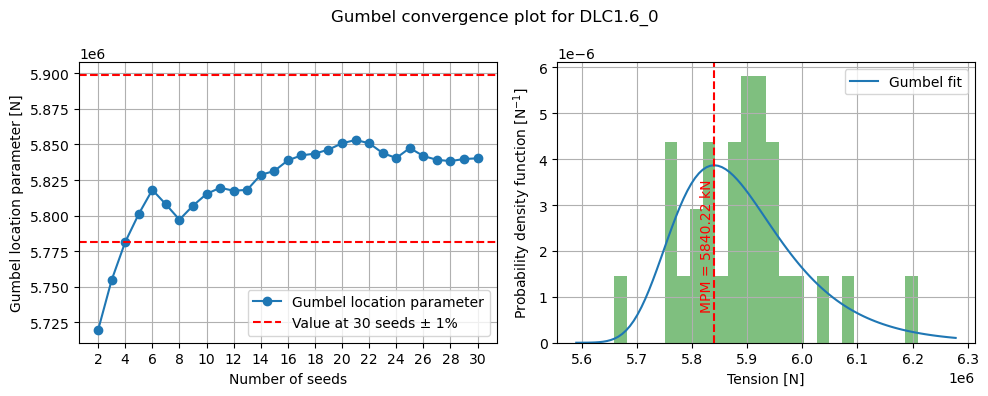

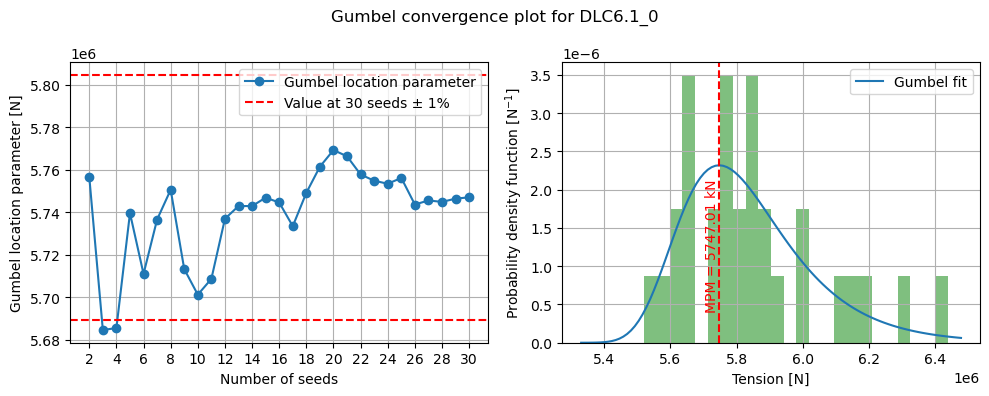

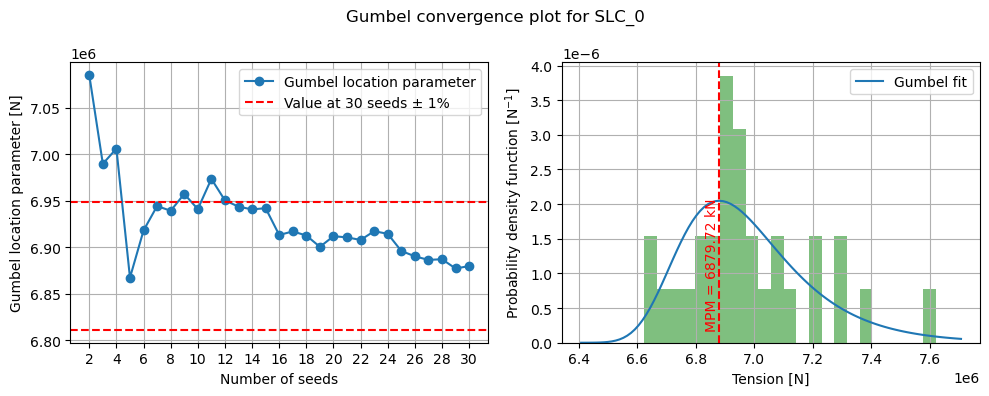

In [37]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
nSeeds = pivot_df.shape[1]

gumbel_locDict = {}
gev_fitDict = {}
maxValsDict = {}

for index, row in pivot_df.iterrows():
    
    maxTenVals = row.values
    
    gumbel_locList = []
    gumbel_scaleList = []
    gumbel_seedList = []

    for i in range(2, len(maxTenVals)+1):
        val = maxTenVals[0:i]
        gumbel_loc, gumbel_scale = gumbel_r.fit(val)
        gumbel_locList.append(gumbel_loc)
        gumbel_scaleList.append(gumbel_scale)
        gumbel_seedList.append(len(val))

    gumbel_locDict[index] = [np.array(gumbel_seedList, dtype=np.int64), np.array(gumbel_locList), np.array(gumbel_scaleList)]

    #also do a GEV fit
    scaledParams = np.array(genextreme.fit(maxTenVals/1e6))  #scale the values to avoid numerical issues
    scaledParams[1:] = scaledParams[1:]*1e6 #leave out teh shape parameter which is not scaled
    gev_fitDict[index] = scaledParams

    maxValsDict[index] = maxTenVals
    

for ind, cond in enumerate(gumbel_locDict.keys()):

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    fig.suptitle(f'Gumbel convergence plot for {cond}')
    
    #gumbel convergence plot
    plt.sca(axs[0])
    plt.plot(gumbel_locDict[cond][0], gumbel_locDict[cond][1], '-o', label = 'Gumbel location parameter')
    tolPercent = 1
    plt.axhline(y = (1 +  tolPercent/100) * gumbel_locDict[cond][1][-1], color='red', linestyle='--', label=f'Value at {nSeeds} seeds ± {tolPercent}%')
    plt.axhline(y = (1 -  tolPercent/100) * gumbel_locDict[cond][1][-1], color='red', linestyle='--')
    plt.xticks(range(2, len(gumbel_locDict[cond][0])+2, 2))
    plt.grid()
    plt.legend()
    plt.xlabel('Number of seeds')
    plt.ylabel('Gumbel location parameter [N]')



    #gumbel pdf
    plt.sca(axs[1])
    gumbel_loc = gumbel_locDict[cond][1][-1]
    gumbel_scale = gumbel_locDict[cond][2][-1]
    x = np.linspace(gumbel_r.ppf(1e-6, scale=gumbel_scale, loc=gumbel_loc),
                    gumbel_r.ppf(0.99, scale=gumbel_scale, loc=gumbel_loc), 100)
    y = gumbel_r.pdf(x, scale=gumbel_scale, loc=gumbel_loc)
    plt.plot(x, y, label='Gumbel fit')
    y_min, y_max = plt.ylim()
    plt.text(gumbel_loc, np.max(y_max - y_min)/2, 
            f"MPM = {gumbel_loc/1000:.2f} kN", rotation=90, ha='right', va='center', color='r')
    plt.axvline(gumbel_loc, color='r', linestyle='--')
    plt.grid()
    plt.xlabel('Tension [N]')
    plt.ylabel(r'Probability density function [N$^{-1}$]')

    #plot the GEV fit
    # gev_fit = gev_fitDict[cond]
    # y_gev = genextreme.pdf(x, c=gev_fit[0], loc=gev_fit[1], scale=gev_fit[2])
    # print(f'Cond {cond} : Shape = {gev_fit[0]:.2f}, Location = {gev_fit[1]:.2f}, Scale = {gev_fit[2]:.2f}')
    # plt.plot(x, y_gev, label='GEV fit')

    #plot histogram
    plt.hist(maxValsDict[cond], bins=30, density=True, alpha=0.5, color='g', range=(x.min(), x.max()))

    plt.legend()

    fig.tight_layout()


### Safety factor check on MPM value

In [38]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')

#gumbel fit
fit_df = pd.DataFrame()
fit_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
fit_df['gumbel_90Quantile'] = fit_df.apply(lambda row: gumbel_r.ppf(0.90, loc=row['gumbel_loc'], scale=row['gumbel_scale']), axis=1)
# pivot_df

#GEV fit
normaliseFact = 1e6 #for GEV fit the data needs to be normalised
fit_df[['gev_shape', 'gev_loc', 'gev_scale']] = pivot_df.apply(lambda row: pd.Series(genextreme.fit(row.values/normaliseFact)), axis=1)
fit_df['gev_loc'] = fit_df['gev_loc']*normaliseFact #scale them back
fit_df['gev_scale'] = fit_df['gev_scale']*normaliseFact 
fit_df['gev_90Quantile'] = fit_df.apply(lambda row: genextreme.ppf(0.90, c=row['gev_shape'], loc=row['gev_loc'], scale=row['gev_scale']), axis=1)

# pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
# pivot_df

Text(1.6, 1.02, 'SLC Safety factor = 1')

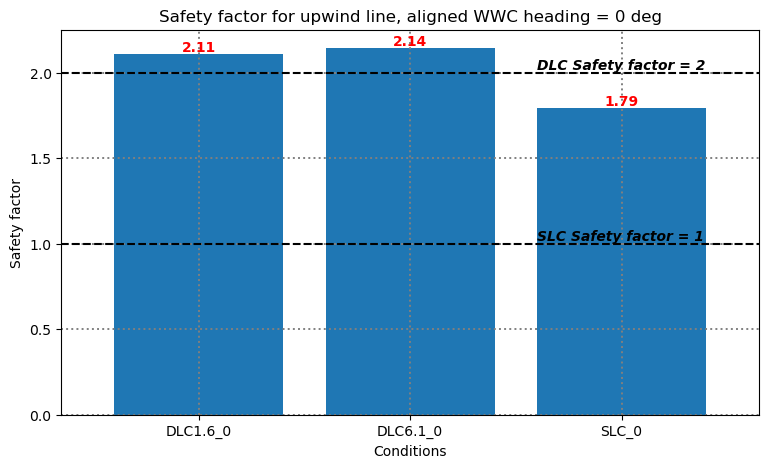

In [39]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
# pivot_df['90Quantile'] = pivot_df.apply(lambda row: gumbel_r.ppf(0.90, loc=row['gumbel_loc'], scale=row['gumbel_scale']), axis=1)

#plot the dataframe
safetyDf = polyMbl/pivot_df[['gumbel_loc']]
# safetyDf = polyMbl/fit_df[['gev_90Quantile']]

safetyDf.plot(kind='bar', figsize=(9, 5), width=0.8)
plt.xticks(rotation=0)
plt.title(f'Safety factor for upwind line, aligned WWC heading = {head} deg')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.legend().remove()
plt.ylabel('Safety factor')
plt.xlabel('Conditions')

for i in range(len(safetyDf)):
    for j in range(len(safetyDf.columns)):
        value = safetyDf.iloc[i, j]  # Get the value from the DataFrame
        plt.annotate(f'{value:.2f}', xy=(i, value), ha='center', va='bottom', color='r', weight='bold')

plt.axhline(y=2, color='k', linestyle='--')
plt.axhline(y=1.0, color='k', linestyle='--')
plt.annotate('DLC Safety factor = 2', xy=(1.6, 2.02), fontstyle='italic', color='k', weight='bold')
plt.annotate('SLC Safety factor = 1', xy=(1.6, 1.02), fontstyle='italic', color='k', weight='bold')

# Minimum line tension at anchor

In [40]:
valHeader =  [f'{ten}{ind}' for ind in range(7,13) for ten in ['ANCHTEN', 'FAIRTEN']]
valType   = 'min'
head = 180
minPd = checkTensionExtremes(sumDf, valHeader, valType, head)
minPd


min tensions occurring in ['ANCHTEN7' 'FAIRTEN7'] and val is 15179.7314453125 @ Run_P200_C135_L1430_clump40_SLC_180_S1.outb


,ANCHTEN7,FAIRTEN7,ANCHTEN8,FAIRTEN8,ANCHTEN9,FAIRTEN9,ANCHTEN10,FAIRTEN10,ANCHTEN11,FAIRTEN11,ANCHTEN12,FAIRTEN12,minTenCol,minTen,cond_head,seed,heading,polyDia
Run_P200_C135_L1430_clump40_DLC1.6_180_S1.outb,368454.875000,383674.718750,383965.750000,399573.093750,604678.68750,636082.93750,637197.56250,671441.00000,672863.93750,683969.43750,685737.5000,767423.1250,ANCHTEN7,368454.875000,DLC1.6_180,01,180.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_180_S10.outb,421642.375000,435421.312500,435593.125000,449269.531250,652185.50000,682569.93750,683313.81250,716291.62500,717409.62500,728150.62500,729534.4375,820333.7500,ANCHTEN7,421642.375000,DLC1.6_180,10,180.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_180_S11.outb,327455.000000,339189.718750,339515.468750,358333.156250,562955.18750,594983.87500,596075.18750,631320.50000,633099.62500,644360.12500,646335.2500,702435.1875,ANCHTEN7,327455.000000,DLC1.6_180,11,180.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_180_S12.outb,369175.625000,382747.156250,383121.500000,398975.718750,604499.87500,636628.25000,637582.12500,672213.56250,673810.62500,685168.31250,687071.2500,768917.2500,ANCHTEN7,369175.625000,DLC1.6_180,12,180.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_180_S13.outb,360814.875000,372717.906250,372968.468750,388699.718750,593350.93750,626133.75000,627297.12500,662428.37500,663699.68750,674551.93750,675959.0000,748513.5625,ANCHTEN7,360814.875000,DLC1.6_180,13,180.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Run_P200_C135_L1430_clump40_SLC_180_S5.outb,191289.453125,199586.453125,200065.250000,230144.250000,427703.06250,456904.28125,458459.28125,495062.46875,496623.21875,507778.28125,509753.4375,537255.8125,ANCHTEN7,191289.453125,SLC_180,05,180.0,0.2
Run_P200_C135_L1430_clump40_SLC_180_S6.outb,233555.765625,250762.343750,251232.187500,275017.625000,475401.62500,505293.87500,506212.18750,540594.87500,542152.81250,553224.62500,555211.5625,611734.4375,ANCHTEN7,233555.765625,SLC_180,06,180.0,0.2
Run_P200_C135_L1430_clump40_SLC_180_S7.outb,250823.171875,259788.828125,260097.265625,280093.906250,483985.25000,514754.84375,516011.71875,549471.56250,550725.93750,561490.68750,563045.5625,625401.8750,ANCHTEN7,250823.171875,SLC_180,07,180.0,0.2
Run_P200_C135_L1430_clump40_SLC_180_S8.outb,258333.109375,277706.250000,278185.875000,298604.906250,501823.46875,531856.00000,532952.93750,567306.56250,568827.12500,579787.93750,581707.8750,647094.8125,ANCHTEN7,258333.109375,SLC_180,08,180.0,0.2


* WWC aligned, 0 deg heading for Line 1 and 3
* WWC aligned, 180 deg heading for Line 2

In [41]:
valHeader = ['ANCHTEN1', 'ANCHTEN7', 'ANCHTEN13']
valType   = 'min'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() 
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']


linHeadDict = {'ANCHTEN1': 0, 
               'ANCHTEN7': 180, 
               'ANCHTEN13': 0}

lineNamesDict = {'ANCHTEN1' : 'Line 1', 
             'ANCHTEN7' : 'Line 2', 
             'ANCHTEN13' : 'Line 3'}

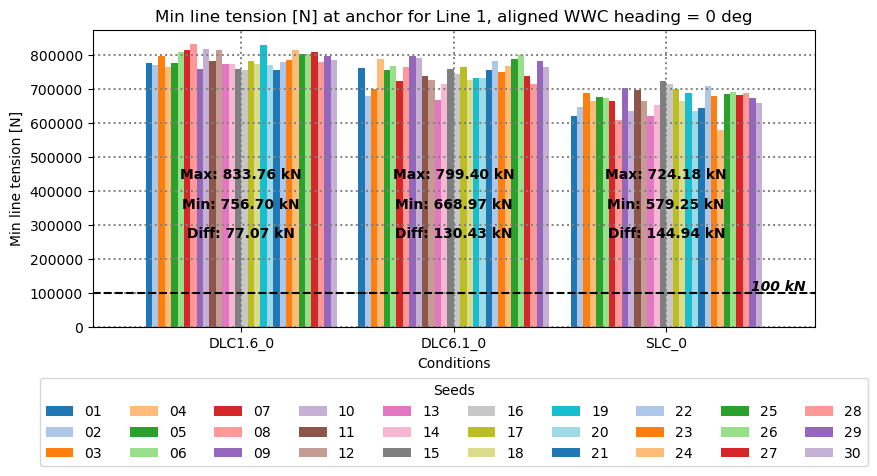

Min line tension [N] at anchor for Line 1, aligned WWC heading = 0 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 775512 | 771569 | 797524 | 766133 | 776116 | 808753 |
| DLC6.1_0    | 761927 | 678559 | 700431 | 788498 | 757102 | 767778 |
| SLC_0       | 621546 | 646645 | 687810 | 664384 | 675337 | 674197 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 816122 | 833765 | 759415 | 818930 | 783593 | 816219 |
| DLC6.1_0    | 724701 | 765622 | 796045 | 791795 | 738908 | 726185 |
| SLC_0       | 666145 | 609078 | 704147 | 633902 | 696130 | 664187 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 773736 | 773191 | 758067 | 756942 | 782983 | 775184 |
| DLC6.1_0    | 668965 | 715922 | 759562 | 744603 | 764986 | 727472 |
| SLC_0       | 621922 | 652286 | 724182 | 714459 | 701288 | 665644 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 829663 | 772166 | 756699 | 780064 | 785822 | 815010 |
| DLC6.1_0    | 731183 | 732664 | 757618 | 781800 | 748940 | 766930 |
| SLC_0       | 688004 | 634178 | 643839 | 710342 | 680750 | 579245 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |     30 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 802178 | 804514 | 808559 | 780748 | 798827 | 786683 |
| DLC6.1_0    | 788695 | 799399 | 737603 | 714951 | 781375 | 766246 |
| SLC_0       | 684207 | 692128 | 681206 | 689166 | 674812 | 659173 |

| cond_head   |    min |    max |
|:------------|-------:|-------:|
| DLC1.6_0    | 756699 | 833765 |
| DLC6.1_0    | 668965 | 799399 |
| SLC_0       | 579245 | 724182 |

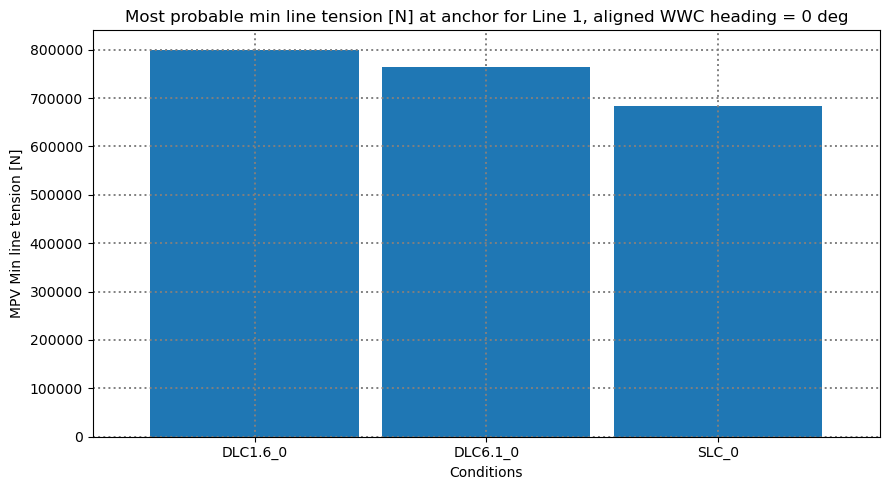

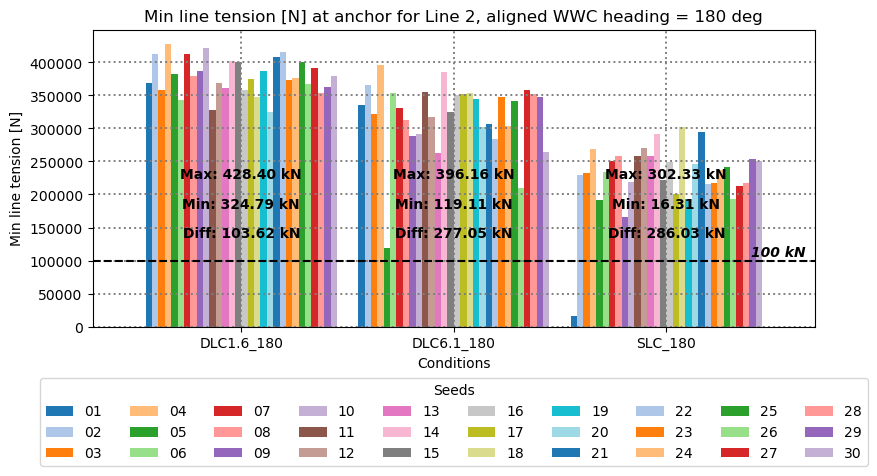

Min line tension [N] at anchor for Line 2, aligned WWC heading = 180 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 368455 | 413010 | 358015 | 428402 | 382975 | 343235 |
| DLC6.1_180  | 335982 | 365793 | 322480 | 396160 | 119110 | 352959 |
| SLC_180     |  16307 | 229930 | 232725 | 268773 | 191289 | 233556 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 412517 | 379529 | 387265 | 421642 | 327455 | 369176 |
| DLC6.1_180  | 331100 | 313036 | 288962 | 291310 | 355566 | 317940 |
| SLC_180     | 250823 | 258333 | 166428 | 218599 | 257833 | 270483 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 360815 | 402325 | 400882 | 357834 | 375289 | 348117 |
| DLC6.1_180  | 262508 | 384907 | 325314 | 351095 | 352027 | 353779 |
| SLC_180     | 257721 | 291455 | 221716 | 249751 | 201246 | 302333 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 387172 | 324786 | 407835 | 416025 | 373640 | 377019 |
| DLC6.1_180  | 344495 | 302686 | 306033 | 284613 | 347624 | 304092 |
| SLC_180     | 192980 | 246513 | 295005 | 216309 | 217024 | 237141 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |     30 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 401305 | 367100 | 391409 | 353937 | 362445 | 378741 |
| DLC6.1_180  | 342264 | 210160 | 358956 | 351948 | 347976 | 263747 |
| SLC_180     | 241719 | 193363 | 212957 | 217954 | 253507 | 250956 |

| cond_head   |    min |    max |
|:------------|-------:|-------:|
| DLC1.6_180  | 324786 | 428402 |
| DLC6.1_180  | 119110 | 396160 |
| SLC_180     |  16307 | 302333 |

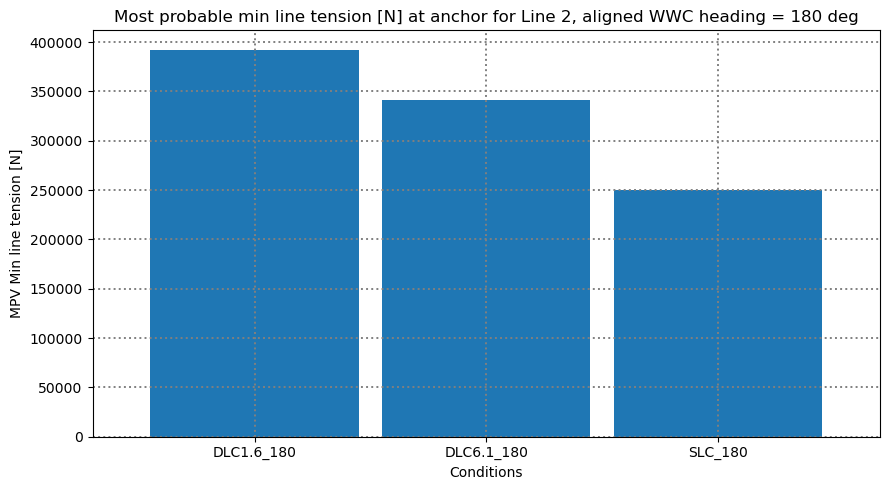

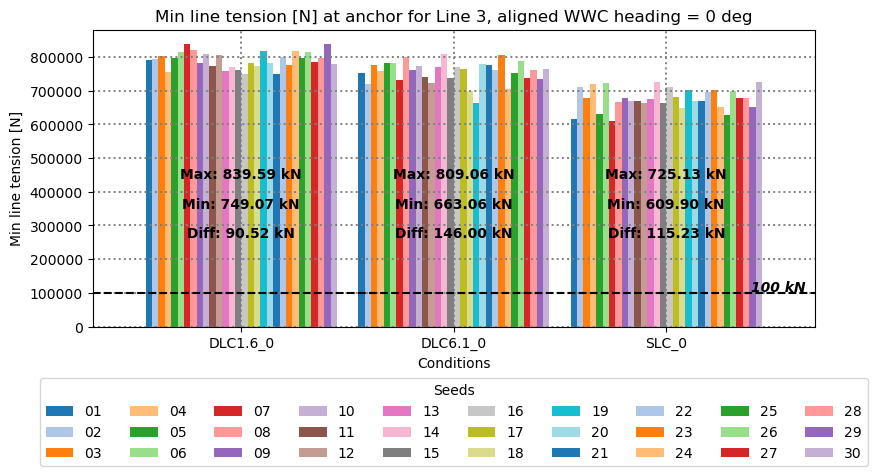

Min line tension [N] at anchor for Line 3, aligned WWC heading = 0 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 790399 | 793782 | 801820 | 755965 | 798517 | 814207 |
| DLC6.1_0    | 752784 | 719038 | 776362 | 759852 | 782399 | 781697 |
| SLC_0       | 616248 | 709588 | 677288 | 719180 | 629557 | 723566 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 839413 | 819748 | 781261 | 809160 | 773691 | 806834 |
| DLC6.1_0    | 732527 | 798914 | 759978 | 772201 | 741642 | 724213 |
| SLC_0       | 609904 | 667392 | 677121 | 668898 | 669830 | 664489 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 759952 | 770205 | 761118 | 750740 | 780911 | 774491 |
| DLC6.1_0    | 769130 | 809059 | 737696 | 769190 | 763603 | 700583 |
| SLC_0       | 674771 | 725130 | 664393 | 709836 | 680056 | 648720 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 817493 | 781829 | 749073 | 800010 | 776835 | 818672 |
| DLC6.1_0    | 663058 | 779993 | 776561 | 762118 | 806297 | 706061 |
| SLC_0       | 702177 | 669590 | 670154 | 697138 | 702903 | 651427 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |     30 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 798051 | 814391 | 785268 | 796393 | 839594 | 780234 |
| DLC6.1_0    | 752134 | 787180 | 736411 | 762188 | 736131 | 764572 |
| SLC_0       | 626804 | 699009 | 678711 | 676908 | 652009 | 724430 |

| cond_head   |    min |    max |
|:------------|-------:|-------:|
| DLC1.6_0    | 749073 | 839594 |
| DLC6.1_0    | 663058 | 809059 |
| SLC_0       | 609904 | 725130 |

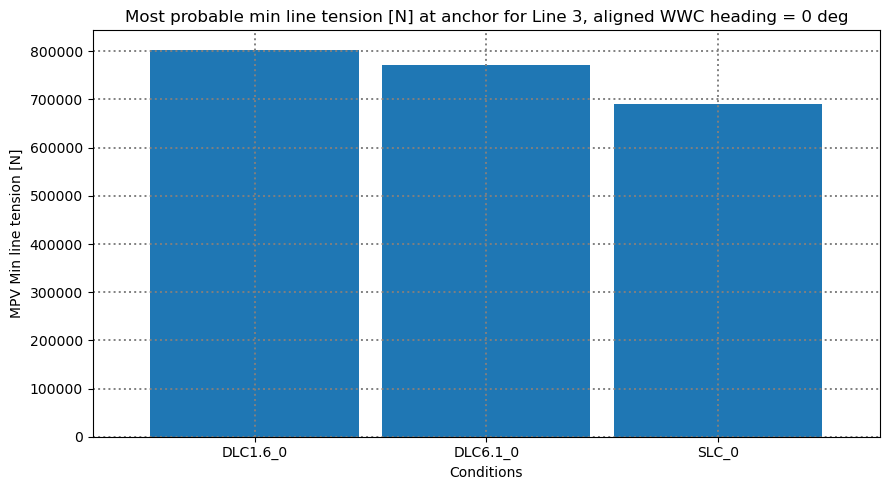

In [42]:
for lineID, head in linHeadDict.items():

    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()

    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)

    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'Min line tension [N]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
    plt.tight_layout()
    


    #minimum tensions
    pivot_df['min'] = pivot_df.min(axis=1)
    pivot_df['max'] = pivot_df.max(axis=1)

    dist =  np.mean(plt.ylim()) * 0.2

    for index, row in pivot_df.iterrows():
        x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
        plt.annotate(f'Max: {row["max"]/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim())),
                    ha='center', color='k', weight='bold')
        plt.annotate(f'Min: {row["min"]/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                    ha='center', color='k', weight='bold')
        #difference
        plt.annotate(f'Diff: {(row["max"]-row["min"])/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                    ha='center', color='k', weight='bold')
 
    plt.axhline(y = 100*1e3, color='k', linestyle='--')
    xLims = plt.xlim() 
    plt.text(xLims[1] -.3, 1.06 * 100*1e3, '100 kN', fontstyle='italic', color='k', weight='bold')
    plt.show()

    print(f"Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg")
    displayDf(pivot_df, nCols = 6)


    


    #------------ plot the most probable minimum tension value -----------
    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()

    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)

    pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_l.fit(row.values)), axis=1)

    pivot_df = pivot_df[['gumbel_loc']]

    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Most probable min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'MPV Min line tension [N]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.tight_layout()
    plt.legend().remove()


    # plt.axhline(y=0.1*preTension, color='k', linestyle='--')
    # plt.annotate('10% of Pretension', xy=(1.6, 1.02 * 0.1 * preTension), fontstyle='italic', color='k', weight='bold')


    

* The min tensions at anchor goes slack for SLC condition eventhough it shows 21.8 kN -> not able to find the reason for this small value to be always present.

# Minimum height of botom chain top node from the seabed

* WWC aligned, 0 deg heading for Line 1 and 3
* WWC aligned, 180 deg heading for Line 2

In [43]:
waterDepth = 800
valHeader = ['CON2PZ', 'CON9PZ', 'CON16PZ']
valType   = 'min'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() + waterDepth #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']


linHeadDict = {'CON2PZ': 0, 
               'CON9PZ': 180, 
               'CON16PZ': 0}

lineNamesDict = {   'CON2PZ' : 'Line 1', 
                    'CON9PZ': 'Line 2', 
                    'CON16PZ' : 'Line 3'}

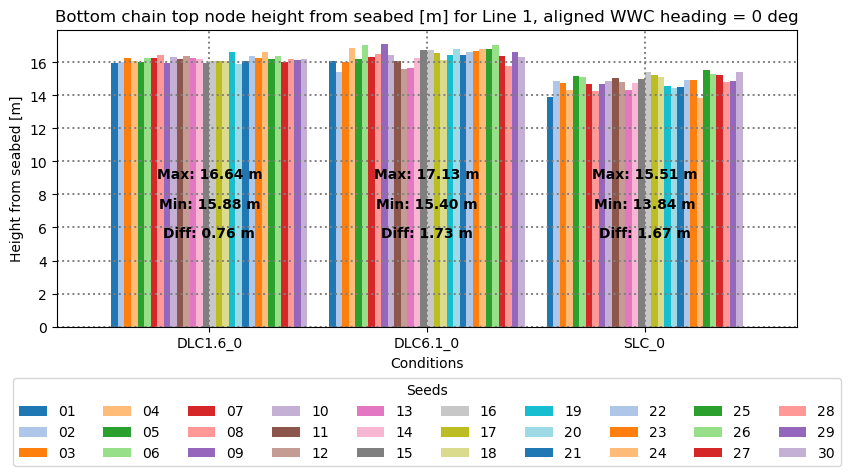

Min line tension [N] at anchor for Line 1, aligned WWC heading = 0 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.9705 | 16.0259 | 16.2789 | 16.0796 | 16.0449 | 16.2518 |
| DLC6.1_0    | 16.0809 | 15.3964 | 16.0508 | 16.88   | 16.2064 | 17.0596 |
| SLC_0       | 13.9144 | 14.8736 | 14.7529 | 14.3383 | 15.1761 | 15.135  |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.2905 | 16.4446 | 15.9353 | 16.3426 | 16.2029 | 16.374  |
| DLC6.1_0    | 16.3109 | 16.5331 | 17.1306 | 16.4514 | 16.0999 | 15.5781 |
| SLC_0       | 14.6901 | 14.2612 | 14.6731 | 14.8855 | 15.0535 | 14.8207 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.2741 | 16.1789 | 15.9753 | 16.0518 | 16.0964 | 16.0659 |
| DLC6.1_0    | 15.679  | 16.2702 | 16.7735 | 16.7197 | 16.5435 | 16.1331 |
| SLC_0       | 14.2953 | 14.7267 | 14.9763 | 15.3925 | 15.2084 | 15.1284 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.6222 | 15.8799 | 16.0735 | 16.4006 | 16.2697 | 16.6386 |
| DLC6.1_0    | 16.4279 | 16.8011 | 16.4222 | 16.6245 | 16.6953 | 16.8224 |
| SLC_0       | 14.5925 | 14.4673 | 14.4929 | 14.9005 | 14.9306 | 13.8406 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.2142 | 16.3619 | 16.0348 | 16.2262 | 16.164  | 16.1952 |
| DLC6.1_0    | 16.8069 | 17.0765 | 16.365  | 15.8083 | 16.6398 | 16.3417 |
| SLC_0       | 15.5065 | 15.3136 | 15.2348 | 14.8217 | 14.8438 | 15.4318 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 15.8799 | 16.6386 |
| DLC6.1_0    | 15.3964 | 17.1306 |
| SLC_0       | 13.8406 | 15.5065 |

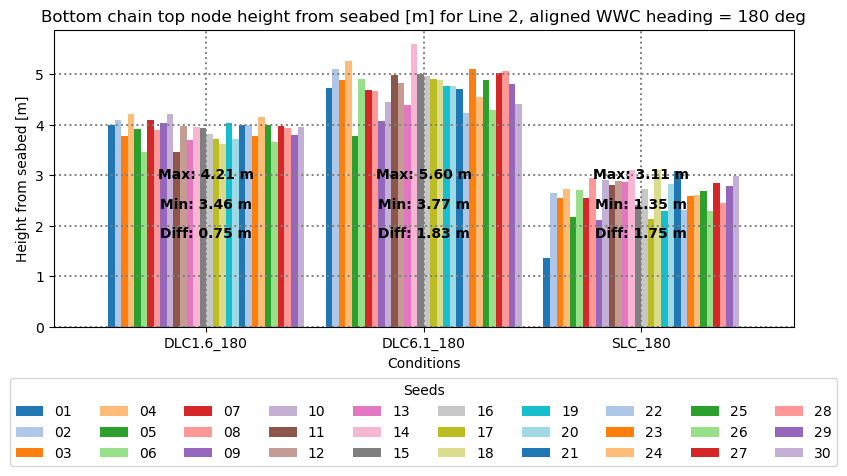

Min line tension [N] at anchor for Line 2, aligned WWC heading = 180 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 3.99603 | 4.08484 | 3.76385 | 4.20563 | 3.91809 | 3.46527 |
| DLC6.1_180  | 4.72742 | 5.10199 | 4.87897 | 5.25842 | 3.76727 | 4.90784 |
| SLC_180     | 1.35437 | 2.6355  | 2.53601 | 2.73328 | 2.17926 | 2.6994  |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.09283 | 3.89508 | 4.03271 | 4.20825 | 3.45984 | 3.97583 |
| DLC6.1_180  | 4.68707 | 4.65839 | 4.07538 | 4.45129 | 4.98792 | 4.81854 |
| SLC_180     | 2.54114 | 2.93646 | 2.10461 | 2.90527 | 2.80865 | 2.88904 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 3.69708 | 3.95142 | 3.92725 | 3.81879 | 3.71204 | 3.61615 |
| DLC6.1_180  | 4.37885 | 5.60181 | 5.00513 | 4.96277 | 4.89252 | 4.89124 |
| SLC_180     | 2.86755 | 3.10669 | 2.40167 | 2.72217 | 2.1377  | 3.10016 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.02795 | 3.7135  | 3.99847 | 3.98151 | 3.78082 | 4.14313 |
| DLC6.1_180  | 4.76147 | 4.76282 | 4.6955  | 4.22168 | 5.10852 | 4.55029 |
| SLC_180     | 2.29785 | 2.81934 | 3.07745 | 2.31573 | 2.59039 | 2.59894 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 3.99371 | 3.65729 | 3.96619 | 3.93829 | 3.78668 | 3.95087 |
| DLC6.1_180  | 4.87512 | 4.27954 | 5.02722 | 5.06757 | 4.80347 | 4.41455 |
| SLC_180     | 2.69019 | 2.29553 | 2.83521 | 2.45325 | 2.78723 | 2.97162 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_180  | 3.45984 | 4.20825 |
| DLC6.1_180  | 3.76727 | 5.60181 |
| SLC_180     | 1.35437 | 3.10669 |

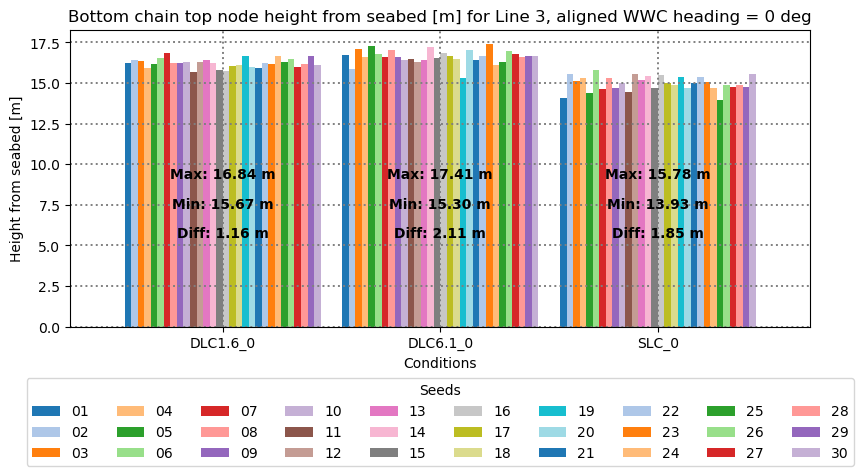

Min line tension [N] at anchor for Line 3, aligned WWC heading = 0 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.1992 | 16.3936 | 16.3715 | 15.8935 | 16.1705 | 16.5616 |
| DLC6.1_0    | 16.6968 | 15.8654 | 17.116  | 16.596  | 17.2686 | 16.7494 |
| SLC_0       | 14.0756 | 15.541  | 15.1149 | 15.3152 | 14.3892 | 15.7811 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.8362 | 16.2336 | 16.2375 | 16.3039 | 15.6733 | 16.2845 |
| DLC6.1_0    | 16.5657 | 16.9974 | 16.5886 | 16.4136 | 16.4471 | 16.2692 |
| SLC_0       | 14.6256 | 15.2876 | 14.6851 | 14.985  | 14.4699 | 15.5225 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.4301 | 16.2104 | 15.8004 | 15.7494 | 16.0549 | 16.0947 |
| DLC6.1_0    | 16.4396 | 17.1884 | 16.5085 | 16.8307 | 16.639  | 16.4972 |
| SLC_0       | 15.1896 | 15.4293 | 14.6657 | 15.4727 | 14.967  | 14.8563 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.6394 | 16.0065 | 15.9319 | 16.2339 | 16.1508 | 16.655  |
| DLC6.1_0    | 15.3034 | 17.0417 | 16.4357 | 16.6765 | 17.4147 | 16.1152 |
| SLC_0       | 15.3603 | 14.6841 | 14.9995 | 15.3448 | 15.0507 | 14.7003 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.2966 | 16.4722 | 15.9777 | 16.1749 | 16.6579 | 16.0751 |
| DLC6.1_0    | 16.3029 | 16.9843 | 16.7906 | 16.6038 | 16.6747 | 16.6467 |
| SLC_0       | 13.9297 | 14.8612 | 14.7721 | 14.8699 | 14.7305 | 15.564  |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 15.6733 | 16.8362 |
| DLC6.1_0    | 15.3034 | 17.4147 |
| SLC_0       | 13.9297 | 15.7811 |

In [44]:
for lineID, head in linHeadDict.items():

    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()
    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Bottom chain top node height from seabed [m] for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'Height from seabed [m]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
    plt.tight_layout()

    #minimum tensions
    pivot_df['min'] = pivot_df.min(axis=1)
    pivot_df['max'] = pivot_df.max(axis=1)

    dist =  np.mean(plt.ylim()) * 0.2

    for index, row in pivot_df.iterrows():
        x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
        plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                    ha='center', color='k', weight='bold')
        plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                    ha='center', color='k', weight='bold')
        #difference
        plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                    ha='center', color='k', weight='bold')
 
        
    plt.show()

    print(f"Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg")
    displayDf(pivot_df, nCols = 6)


# Max line tension at anchor

* WWC aligned, 0 deg heading for Line 2

In [45]:
valHeader = ['ANCHTEN7', 'LINE7N0FZ', 'ANCH7HORZ']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() 
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']

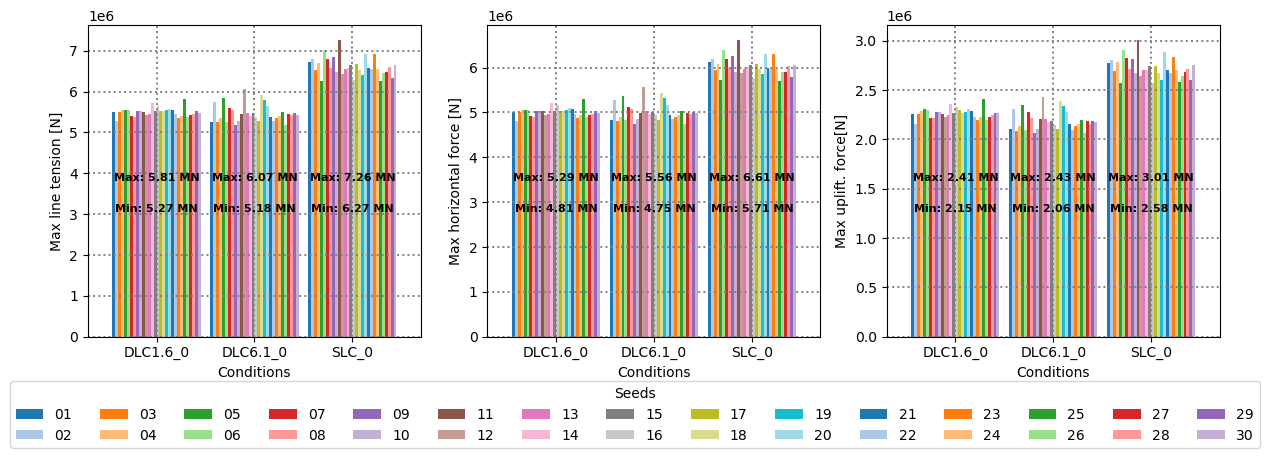

In [46]:
head = 0
filt = maxPd['heading'] == head #select the heading case based on the line considered
headFiltDf = maxPd[filt].copy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


#Line tension at anchor
lineID = 'ANCHTEN7'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, ax = axs[0], legend = False)   
plt.sca(axs[0])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max line tension [N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)



#Line horizontal tension max at anchor
lineID = 'ANCH7HORZ'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, ax = axs[1], legend = False)   
plt.sca(axs[1])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max horizontal force [N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)

#Line vertical tension max at anchor
lineID = 'LINE7N0FZ'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, legend = False, ax = axs[2])   
plt.sca(axs[2])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max uplift. force[N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title = 'Seeds', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=15)
#get the legend
fig.tight_layout()


# plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
# fig.tight_layout()



## Load inclination angle

In [47]:
#Design case
#Maximum tension at the anchor
df = df[df['heading'] == 0] 
df.loc[df.groupby('cond_head')['ANCHTEN7_[N]'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C135_L1430_clump40_DLC1.6_0_S25.outb,ANCHTEN7_[N],2001.925,5.814323e+06,24.476930,5.291744e+06,2.409014e+06
Run_P200_C135_L1430_clump40_DLC6.1_0_S12.outb,ANCHTEN7_[N],3977.125,6.065522e+06,23.606297,5.557962e+06,2.428942e+06
Run_P200_C135_L1430_clump40_SLC_0_S11.outb,ANCHTEN7_[N],1360.925,7.264838e+06,24.429160,6.614444e+06,3.004505e+06


In [48]:
df = df[df['heading'] == 0] 
#Maximum horizontal tension at the anchor
df.loc[df.groupby('cond_head')['LINE7ANCH_HOR_TEN'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C135_L1430_clump40_DLC1.6_0_S25.outb,LINE7ANCH_HOR_TEN,2001.9,5.814194e+06,24.473936,5.291802e+06,2.408706e+06
Run_P200_C135_L1430_clump40_DLC6.1_0_S12.outb,LINE7ANCH_HOR_TEN,3977.1,6.065456e+06,23.601900,5.558082e+06,2.428486e+06
Run_P200_C135_L1430_clump40_SLC_0_S11.outb,LINE7ANCH_HOR_TEN,1360.9,7.264661e+06,24.424254,6.614523e+06,3.003858e+06


In [49]:
#Maximum vertical tension at the anchor
df = df[df['heading'] == 0] 
df.loc[df.groupby('cond_head')['LINE7N0FZ_[N]'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C135_L1430_clump40_DLC1.6_0_S25.outb,LINE7N0FZ_[N],2002.125,5.812190e+06,24.500256,5.288873e+06,2.410307e+06
Run_P200_C135_L1430_clump40_DLC6.1_0_S12.outb,LINE7N0FZ_[N],3977.275,6.062866e+06,23.631194,5.554443e+06,2.430279e+06
Run_P200_C135_L1430_clump40_SLC_0_S11.outb,LINE7N0FZ_[N],1361.150,7.259818e+06,24.469338,6.607747e+06,3.007054e+06


Teh maximums are occuring at the same time - so the inclination angle does not seem to have any large effect

# Platform mean surge offset

In [50]:
valHeader = ['PtfmSurge']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']

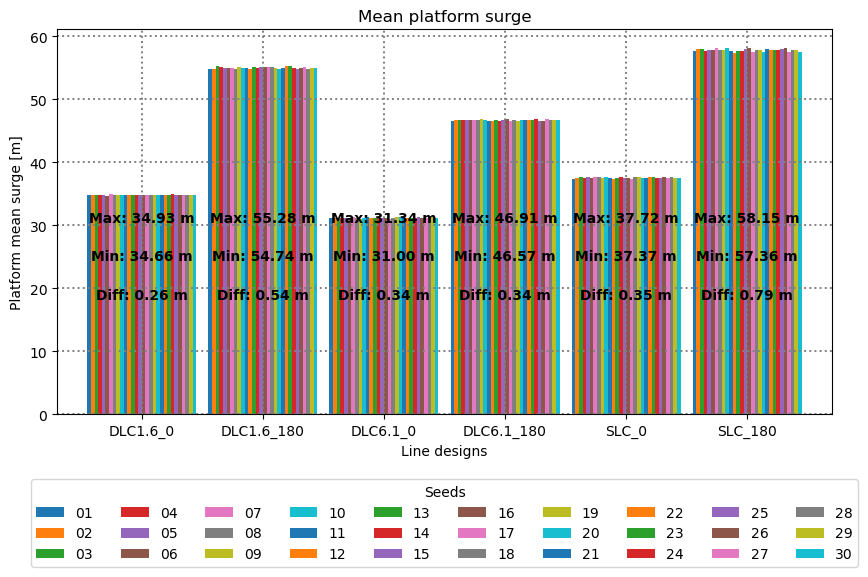

Mean platform surge [m]


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 34.7953 | 34.7342 | 34.8187 | 34.839  | 34.8077 | 34.6642 |
| DLC1.6_180  | 54.8508 | 54.7384 | 55.2035 | 55.0716 | 54.9341 | 54.9605 |
| DLC6.1_0    | 31.1241 | 31.1743 | 30.9973 | 31.0693 | 31.2004 | 31.0384 |
| DLC6.1_180  | 46.579  | 46.6854 | 46.6295 | 46.6443 | 46.7271 | 46.688  |
| SLC_0       | 37.3668 | 37.4757 | 37.5894 | 37.4779 | 37.5668 | 37.4406 |
| SLC_180     | 57.6241 | 58.0001 | 57.902  | 57.6603 | 57.7974 | 57.8517 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 34.8726 | 34.806  | 34.769  | 34.7474 | 34.7909 | 34.7871 |
| DLC1.6_180  | 54.8568 | 54.7677 | 55.0582 | 54.8564 | 54.9986 | 54.7462 |
| DLC6.1_0    | 31.342  | 31.0856 | 31.0064 | 31.1552 | 31.2646 | 31.1424 |
| DLC6.1_180  | 46.6168 | 46.699  | 46.8849 | 46.6671 | 46.5996 | 46.5722 |
| SLC_0       | 37.6459 | 37.5992 | 37.5392 | 37.7182 | 37.4605 | 37.3889 |
| SLC_180     | 58.0727 | 57.7862 | 57.7882 | 58.1467 | 57.6228 | 57.3587 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 34.7634 | 34.7217 | 34.7529 | 34.7129 | 34.7674 | 34.8573 |
| DLC1.6_180  | 55.0872 | 54.8993 | 55.0129 | 55.0421 | 55.1292 | 55.0963 |
| DLC6.1_0    | 31.2008 | 31.0691 | 31.2103 | 31.0863 | 31.0355 | 31.1837 |
| DLC6.1_180  | 46.7071 | 46.5928 | 46.6134 | 46.8429 | 46.5892 | 46.7343 |
| SLC_0       | 37.5133 | 37.5897 | 37.5529 | 37.4926 | 37.3936 | 37.57   |
| SLC_180     | 57.6136 | 57.5929 | 57.8833 | 58.1528 | 57.4231 | 57.7649 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 34.784  | 34.7803 | 34.8043 | 34.8185 | 34.741  | 34.9267 |
| DLC1.6_180  | 54.8704 | 54.8224 | 54.9047 | 55.2754 | 55.1884 | 54.9331 |
| DLC6.1_0    | 31.2758 | 31.2234 | 31.1503 | 31.1471 | 31.1106 | 31.1577 |
| DLC6.1_180  | 46.5941 | 46.6898 | 46.6322 | 46.7171 | 46.7566 | 46.9111 |
| SLC_0       | 37.6354 | 37.4738 | 37.5473 | 37.5681 | 37.5686 | 37.5017 |
| SLC_180     | 57.7272 | 57.4768 | 57.8861 | 57.7284 | 57.8269 | 57.7953 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 34.8142 | 34.8379 | 34.7152 | 34.7873 | 34.736  | 34.7473 |
| DLC1.6_180  | 54.8375 | 54.8893 | 55.0989 | 54.8203 | 54.9153 | 54.9828 |
| DLC6.1_0    | 31.2237 | 31.1005 | 31.1656 | 31.2695 | 31.2345 | 31.2085 |
| DLC6.1_180  | 46.589  | 46.59   | 46.891  | 46.6932 | 46.6601 | 46.6574 |
| SLC_0       | 37.5187 | 37.6366 | 37.5497 | 37.581  | 37.4636 | 37.5622 |
| SLC_180     | 58.0211 | 58.0636 | 57.4633 | 57.7153 | 57.7145 | 57.5079 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 34.6642 | 34.9267 |
| DLC1.6_180  | 54.7384 | 55.2754 |
| DLC6.1_0    | 30.9973 | 31.342  |
| DLC6.1_180  | 46.5722 | 46.9111 |
| SLC_0       | 37.3668 | 37.7182 |
| SLC_180     | 57.3587 | 58.1528 |

In [51]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='PtfmSurge')

pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Line designs')
plt.ylabel('Platform mean surge [m]')
plt.xticks(rotation=0)
plt.title('Mean platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Mean platform surge [m]')
displayDf(pivot_df, nCols = 6)

## Platform heave

In [52]:
valHeader = ['PtfmHeave']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']

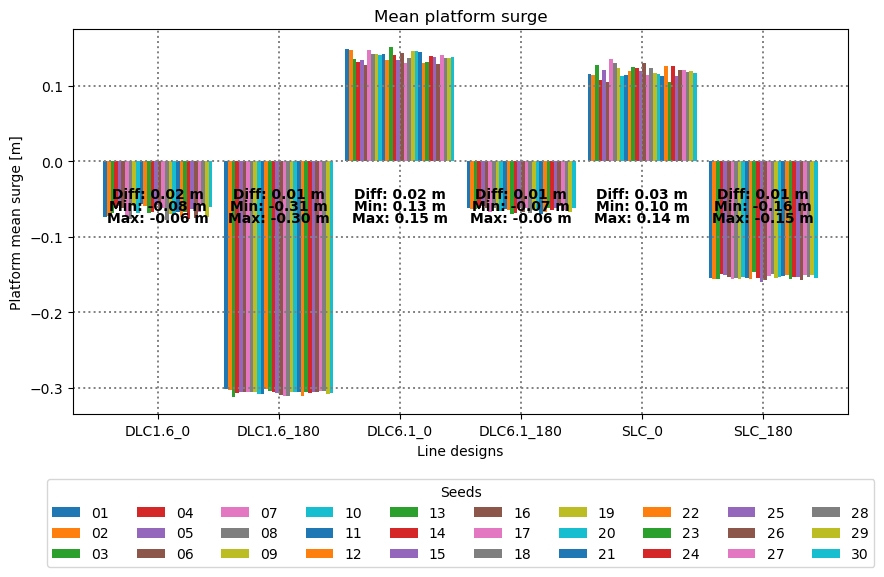

Mean platform surge [m]


| cond_head   |         01 |         02 |         03 |         04 |         05 |         06 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0732399 | -0.0725614 | -0.0681165 | -0.0618614 | -0.0590361 | -0.0624492 |
| DLC1.6_180  | -0.300917  | -0.302665  | -0.311739  | -0.306662  | -0.304844  | -0.305193  |
| DLC6.1_0    |  0.147966  |  0.14698   |  0.135073  |  0.131786  |  0.133847  |  0.126843  |
| DLC6.1_180  | -0.0613639 | -0.0635227 | -0.0630333 | -0.0624619 | -0.059449  | -0.0622238 |
| SLC_0       |  0.115603  |  0.11358   |  0.127263  |  0.106738  |  0.120653  |  0.104508  |
| SLC_180     | -0.154293  | -0.155897  | -0.156454  | -0.149207  | -0.150775  | -0.153149  |

| cond_head   |         07 |         08 |         09 |         10 |         11 |         12 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.07427   | -0.0767193 | -0.0587742 | -0.068964  | -0.0569932 | -0.0596097 |
| DLC1.6_180  | -0.305522  | -0.305684  | -0.305631  | -0.307995  | -0.308177  | -0.301623  |
| DLC6.1_0    |  0.14742   |  0.141287  |  0.141104  |  0.139813  |  0.14133   |  0.133916  |
| DLC6.1_180  | -0.0671443 | -0.0614485 | -0.066185  | -0.0656689 | -0.0638842 | -0.0652178 |
| SLC_0       |  0.135025  |  0.129854  |  0.123595  |  0.112537  |  0.113366  |  0.11886   |
| SLC_180     | -0.156206  | -0.154377  | -0.156414  | -0.153142  | -0.155021  | -0.156026  |

| cond_head   |         13 |         14 |         15 |         16 |         17 |         18 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0685634 | -0.06729   | -0.0576031 | -0.0638878 | -0.062373  | -0.0774402 |
| DLC1.6_180  | -0.304303  | -0.305909  | -0.307212  | -0.309693  | -0.310006  | -0.310798  |
| DLC6.1_0    |  0.151168  |  0.14075   |  0.134067  |  0.142417  |  0.130405  |  0.136636  |
| DLC6.1_180  | -0.0699284 | -0.0685287 | -0.062113  | -0.0668472 | -0.0621292 | -0.0689172 |
| SLC_0       |  0.12452   |  0.122924  |  0.119744  |  0.129358  |  0.114535  |  0.123316  |
| SLC_180     | -0.146156  | -0.155085  | -0.159637  | -0.156605  | -0.151355  | -0.149293  |

| cond_head   |         19 |         20 |         21 |         22 |         23 |         24 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0704792 | -0.0701095 | -0.0666445 | -0.0739413 | -0.0678982 | -0.076095  |
| DLC1.6_180  | -0.30595   | -0.305717  | -0.305456  | -0.310412  | -0.305869  | -0.306855  |
| DLC6.1_0    |  0.145448  |  0.145371  |  0.143968  |  0.129951  |  0.131724  |  0.138949  |
| DLC6.1_180  | -0.0648735 | -0.0640861 | -0.0696236 | -0.0670258 | -0.0621514 | -0.0651718 |
| SLC_0       |  0.116362  |  0.115878  |  0.112201  |  0.125432  |  0.105097  |  0.125936  |
| SLC_180     | -0.154918  | -0.153789  | -0.151478  | -0.150982  | -0.155656  | -0.15375   |

| cond_head   |         25 |         26 |         27 |         28 |         29 |         30 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0626775 | -0.075194  | -0.0670292 | -0.0588973 | -0.0738969 | -0.0609551 |
| DLC1.6_180  | -0.305405  | -0.305861  | -0.304638  | -0.303741  | -0.307731  | -0.306823  |
| DLC6.1_0    |  0.138247  |  0.12862   |  0.140999  |  0.136749  |  0.136552  |  0.137737  |
| DLC6.1_180  | -0.0621226 | -0.0595597 | -0.0639713 | -0.0653774 | -0.0674653 | -0.0625267 |
| SLC_0       |  0.112094  |  0.1208    |  0.120925  |  0.117657  |  0.119159  |  0.116131  |
| SLC_180     | -0.153393  | -0.157694  | -0.151     | -0.15262   | -0.150379  | -0.154132  |

| cond_head   |        min |        max |
|:------------|-----------:|-----------:|
| DLC1.6_0    | -0.0774402 | -0.0569932 |
| DLC1.6_180  | -0.311739  | -0.300917  |
| DLC6.1_0    |  0.126843  |  0.151168  |
| DLC6.1_180  | -0.0699284 | -0.059449  |
| SLC_0       |  0.104508  |  0.135025  |
| SLC_180     | -0.159637  | -0.146156  |

In [53]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='PtfmHeave')

# pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
# pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
# pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Line designs')
plt.ylabel('Platform mean surge [m]')
plt.xticks(rotation=0)
plt.title('Mean platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Mean platform surge [m]')
displayDf(pivot_df, nCols = 6)

# Maximum platform surge offset

In [54]:
valHeader = ['PtfmSurge']
valType   = 'max'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']



valHeader = ['PtfmSurge']
valType   = 'min'
dataDf2               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line


dataDf3 = dataDf1.copy()
filt = dataDf3['PtfmSurge'] < 0
dataDf3.loc[filt, 'PtfmSurge'] = -1*dataDf2.loc[filt, 'PtfmSurge'] #replace the negative values with the min values, and make them positive


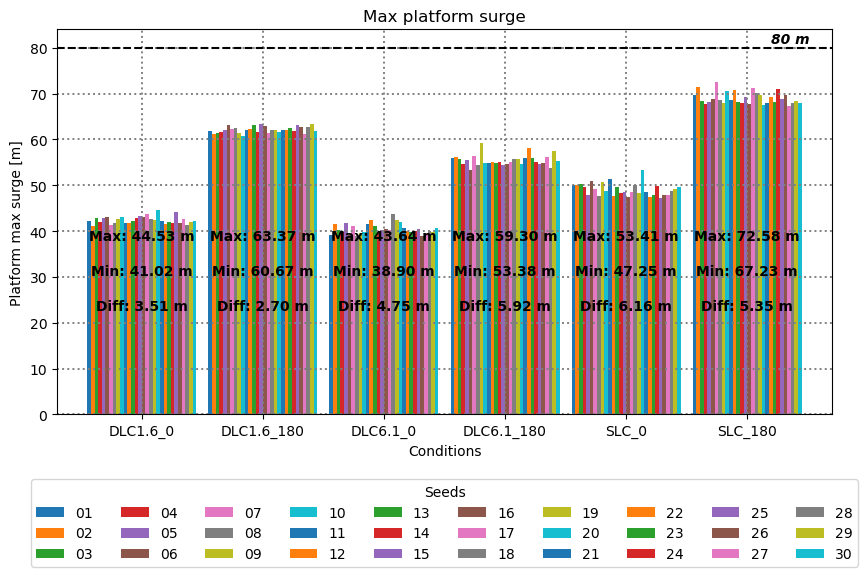

Max platform surge [m]


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 42.2934 | 41.0157 | 42.8711 | 42.0235 | 42.8265 | 43.1403 |
| DLC1.6_180  | 61.7543 | 61.1886 | 61.3508 | 61.5477 | 62.123  | 63.1017 |
| DLC6.1_0    | 39.1413 | 41.4477 | 40.1958 | 39.887  | 41.7809 | 39.1128 |
| DLC6.1_180  | 55.8287 | 56.1163 | 55.6352 | 54.638  | 55.4427 | 53.3802 |
| SLC_0       | 50.0962 | 50.0193 | 50.2856 | 49.7118 | 47.7648 | 50.8101 |
| SLC_180     | 69.7654 | 71.3573 | 68.3089 | 67.6605 | 68.2556 | 68.7921 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 41.305  | 41.6426 | 42.7279 | 43.152  | 41.6918 | 41.675  |
| DLC1.6_180  | 62.1987 | 62.504  | 61.4182 | 60.6712 | 61.9797 | 62.1956 |
| DLC6.1_0    | 41.1122 | 38.9814 | 39.6254 | 39.8623 | 41.5511 | 42.4318 |
| DLC6.1_180  | 56.4129 | 54.4633 | 59.2998 | 54.8673 | 54.884  | 55.1537 |
| SLC_0       | 49.1229 | 47.7455 | 50.6329 | 48.7931 | 51.2466 | 47.694  |
| SLC_180     | 72.5814 | 68.5844 | 68.0412 | 70.5631 | 68.6918 | 70.7309 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 42.2392 | 42.7989 | 43.2725 | 42.9884 | 43.7638 | 42.6566 |
| DLC1.6_180  | 63.2073 | 61.6412 | 63.2469 | 62.9641 | 61.3999 | 62.0252 |
| DLC6.1_0    | 41.0146 | 39.9095 | 40.215  | 40.4307 | 40.1813 | 43.6417 |
| DLC6.1_180  | 54.7789 | 55.0167 | 54.4809 | 54.6613 | 55.1113 | 55.822  |
| SLC_0       | 49.6766 | 48.2212 | 48.6124 | 47.4462 | 48.4211 | 50.075  |
| SLC_180     | 68.236  | 67.9781 | 69.1343 | 67.6164 | 71.297  | 70.1722 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 42.346  | 44.526  | 42.2844 | 41.5151 | 41.9051 | 41.6872 |
| DLC1.6_180  | 61.9934 | 61.6384 | 62.0199 | 62.0408 | 62.4544 | 61.7586 |
| DLC6.1_0    | 42.5131 | 42.0042 | 40.6504 | 39.9102 | 39.7956 | 40.0861 |
| DLC6.1_180  | 55.7423 | 54.703  | 55.889  | 58.0909 | 55.9489 | 55.1257 |
| SLC_0       | 48.3469 | 53.4063 | 48.614  | 47.4036 | 47.8387 | 49.8744 |
| SLC_180     | 69.5959 | 67.5212 | 67.8284 | 69.1618 | 68.2483 | 70.9563 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 44.2531 | 41.6505 | 42.579  | 41.2512 | 41.9927 | 42.2459 |
| DLC1.6_180  | 63.0297 | 62.776  | 61.2236 | 62.6895 | 63.3667 | 61.768  |
| DLC6.1_0    | 40.5266 | 38.8963 | 39.6125 | 39.9733 | 39.7799 | 40.7064 |
| DLC6.1_180  | 54.5897 | 54.8052 | 56.0717 | 53.7278 | 57.4123 | 55.3195 |
| SLC_0       | 47.2501 | 47.7682 | 47.9306 | 48.8393 | 49.0663 | 49.6475 |
| SLC_180     | 68.8752 | 69.6162 | 67.2329 | 67.9527 | 68.4447 | 67.9354 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 41.0157 | 44.526  |
| DLC1.6_180  | 60.6712 | 63.3667 |
| DLC6.1_0    | 38.8963 | 43.6417 |
| DLC6.1_180  | 53.3802 | 59.2998 |
| SLC_0       | 47.2501 | 53.4063 |
| SLC_180     | 67.2329 | 72.5814 |

In [55]:
pivot_df = dataDf3.pivot(index='cond_head', columns='seed', values='PtfmSurge')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform max surge [m]')
plt.xticks(rotation=0)
plt.title('Max platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')


plt.axhline(y =80, color='k', linestyle='--')
xLims = plt.xlim() 
plt.text(xLims[1] -.5, 81, '80 m', fontstyle='italic', color='k', weight='bold')


plt.show()

print('Max platform surge [m]')
displayDf(pivot_df, nCols = 6)



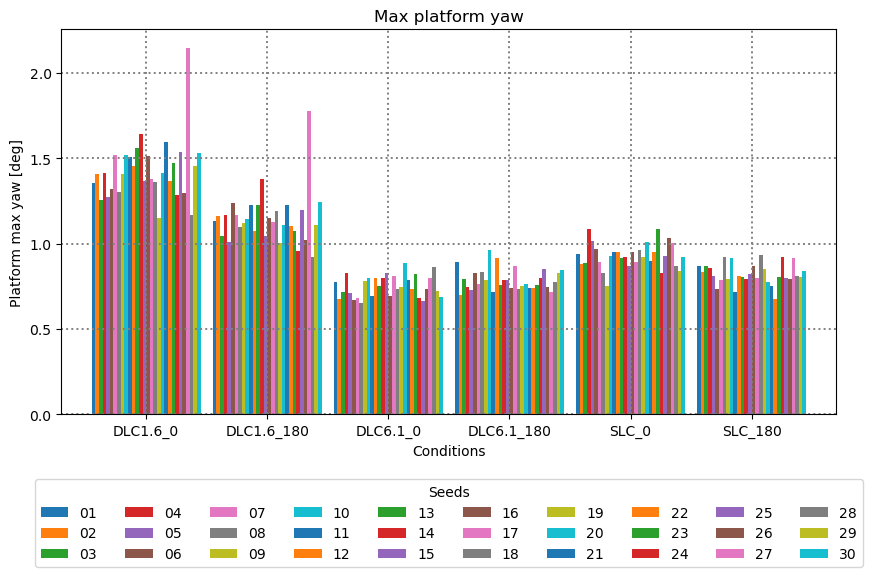

In [56]:

valHeader = ['PtfmYaw']
valType   = 'max'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']

pivot_df = dataDf1.pivot(index='cond_head', columns='seed', values='PtfmYaw')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform max yaw [deg]')
plt.xticks(rotation=0)
plt.title('Max platform yaw')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



# pivot_df['min'] = pivot_df.min(axis=1)
# pivot_df['max'] = pivot_df.max(axis=1)

# dist =  np.mean(plt.ylim()) * 0.2

# for index, row in pivot_df.iterrows():
#     x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
#     plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
#                 ha='center', color='k', weight='bold')
#     plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
#                 ha='center', color='k', weight='bold')
#     #difference
#     plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
#                 ha='center', color='k', weight='bold')

# plt.show()

# print('Max platform surge [m]')
# displayDf(pivot_df, nCols = 6)

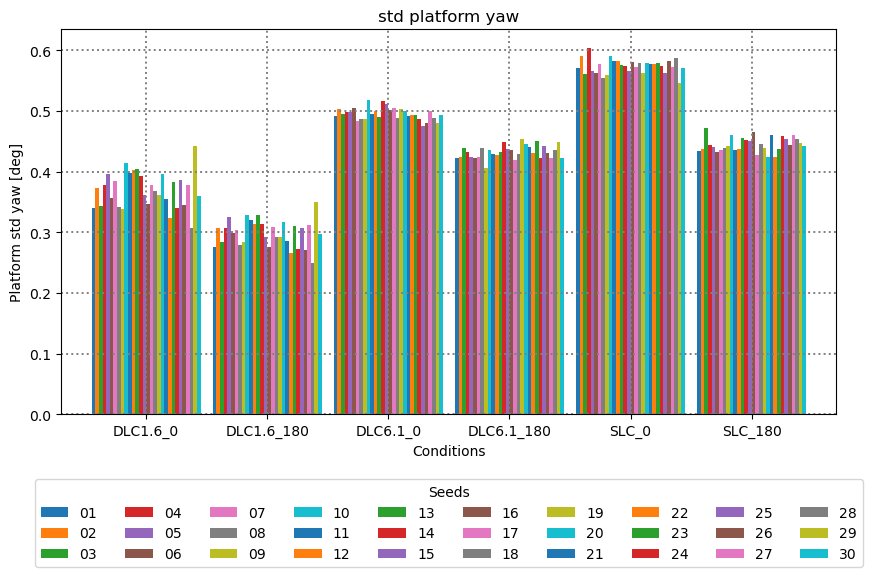

In [57]:

valHeader = ['PtfmYaw']
valType   = 'std'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']

pivot_df = dataDf1.pivot(index='cond_head', columns='seed', values='PtfmYaw')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform std yaw [deg]')
plt.xticks(rotation=0)
plt.title('std platform yaw')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
